In [1]:
from data_preparation import DataProcessor
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from catboost import CatBoostRegressor

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

In [2]:
waste_data = pd.read_csv("synthetic_waste_data.csv")

# Create an instance of FetchData
fetcher = DataProcessor(waste_data)

# Prepare the data
prepared_data = fetcher.prepare_quantity_tons()
prepared_data

date  is_weekend  is_holiday  is_Fall  is_Spring  is_Summer  \
0    2022-01-01         1.0         1.0      0.0        0.0        0.0   
1    2022-01-02         1.0         0.0      0.0        0.0        0.0   
2    2022-01-03         0.0         0.0      0.0        0.0        0.0   
3    2022-01-04         0.0         0.0      0.0        0.0        0.0   
4    2022-01-05         0.0         0.0      0.0        0.0        0.0   
...         ...         ...         ...      ...        ...        ...   
1091 2024-12-27         0.0         0.0      0.0        0.0        0.0   
1092 2024-12-28         1.0         0.0      0.0        0.0        0.0   
1093 2024-12-29         1.0         0.0      0.0        0.0        0.0   
1094 2024-12-30         0.0         0.0      0.0        0.0        0.0   
1095 2024-12-31         0.0         0.0      0.0        0.0        0.0   

      is_Winter  quantity_tons  
0           1.0     153.851503  
1           1.0     245.846278  
2           1.0     574.139774  
3           1.0     446.454597  
4           1.0     141.906455  
...         ...            ...  
1091        1.0     865.147110  
1092        1.0     252.648480  
1093        1.0      72.427480  
1094        1.0     307.403118  
1095        1.0     211.884785  

[1096 rows x 8 columns]

In [3]:
feature_data = fetcher.create_boosting_features(prepared_data)
feature_data

is_weekend  is_holiday  is_Fall  is_Spring  is_Summer  is_Winter  \
date                                                                           
2022-01-01         1.0         1.0      0.0        0.0        0.0        1.0   
2022-01-02         1.0         0.0      0.0        0.0        0.0        1.0   
2022-01-03         0.0         0.0      0.0        0.0        0.0        1.0   
2022-01-04         0.0         0.0      0.0        0.0        0.0        1.0   
2022-01-05         0.0         0.0      0.0        0.0        0.0        1.0   
...                ...         ...      ...        ...        ...        ...   
2024-12-27         0.0         0.0      0.0        0.0        0.0        1.0   
2024-12-28         1.0         0.0      0.0        0.0        0.0        1.0   
2024-12-29         1.0         0.0      0.0        0.0        0.0        1.0   
2024-12-30         0.0         0.0      0.0        0.0        0.0        1.0   
2024-12-31         0.0         0.0      0.0        0.0        0.0        1.0   

            quantity_tons  dayofweek  quarter  month  year  dayofyear  \
date                                                                    
2022-01-01     153.851503          5        1      1  2022          1   
2022-01-02     245.846278          6        1      1  2022          2   
2022-01-03     574.139774          0        1      1  2022          3   
2022-01-04     446.454597          1        1      1  2022          4   
2022-01-05     141.906455          2        1      1  2022          5   
...                   ...        ...      ...    ...   ...        ...   
2024-12-27     865.147110          4        4     12  2024        362   
2024-12-28     252.648480          5        4     12  2024        363   
2024-12-29      72.427480          6        4     12  2024        364   
2024-12-30     307.403118          0        4     12  2024        365   
2024-12-31     211.884785          1        4     12  2024        366   

            dayofmonth  weekofyear  
date                                
2022-01-01           1          52  
2022-01-02           2          52  
2022-01-03           3           1  
2022-01-04           4           1  
2022-01-05           5           1  
...                ...         ...  
2024-12-27          27          52  
2024-12-28          28          52  
2024-12-29          29          52  
2024-12-30          30           1  
2024-12-31          31           1  

[1096 rows x 14 columns]

In [3]:
feature_data = fetcher.create_lagged_boosting_features(prepared_data)
feature_data

is_weekend  is_holiday  is_Fall  is_Spring  is_Summer  is_Winter  \
date                                                                           
2023-01-01         1.0         1.0      0.0        0.0        0.0        1.0   
2023-01-02         0.0         0.0      0.0        0.0        0.0        1.0   
2023-01-03         0.0         0.0      0.0        0.0        0.0        1.0   
2023-01-04         0.0         0.0      0.0        0.0        0.0        1.0   
2023-01-05         0.0         0.0      0.0        0.0        0.0        1.0   
...                ...         ...      ...        ...        ...        ...   
2024-12-27         0.0         0.0      0.0        0.0        0.0        1.0   
2024-12-28         1.0         0.0      0.0        0.0        0.0        1.0   
2024-12-29         1.0         0.0      0.0        0.0        0.0        1.0   
2024-12-30         0.0         0.0      0.0        0.0        0.0        1.0   
2024-12-31         0.0         0.0      0.0        0.0        0.0        1.0   

            quantity_tons  dayofweek  quarter  month  ...  dayofyear  \
date                                                  ...              
2023-01-01      34.342541          6        1      1  ...          1   
2023-01-02     651.984764          0        1      1  ...          2   
2023-01-03     617.339912          1        1      1  ...          3   
2023-01-04     429.640840          2        1      1  ...          4   
2023-01-05     250.866191          3        1      1  ...          5   
...                   ...        ...      ...    ...  ...        ...   
2024-12-27     865.147110          4        4     12  ...        362   
2024-12-28     252.648480          5        4     12  ...        363   
2024-12-29      72.427480          6        4     12  ...        364   
2024-12-30     307.403118          0        4     12  ...        365   
2024-12-31     211.884785          1        4     12  ...        366   

            dayofmonth  weekofyear  lag_ratio_1  lag_ratio_2  lag_ratio_3  \
date                                                                        
2023-01-01           1          52     0.251298     0.111117     0.105953   
2023-01-02           2           1    18.984756     4.770825     2.109531   
2023-01-03           3           1     0.946862    17.975953     4.517315   
2023-01-04           4           1     0.695955     0.658974    12.510456   
2023-01-05           5           1     0.583897     0.406366     0.384773   
...                ...         ...          ...          ...          ...   
2024-12-27          27          52     1.050451     2.576238     1.244604   
2024-12-28          28          52     0.292030     0.306763     0.752337   
2024-12-29          29          52     0.286673     0.083717     0.087941   
2024-12-30          30           1     4.244288     1.216723     0.355319   
2024-12-31          31           1     0.689273     2.925475     0.838655   

            lag_ratio_4  lag_ratio_5  lag_ratio_6  lag_ratio_365  
date                                                              
2023-01-01     0.070196     0.036751     0.040712       0.223219  
2023-01-02     2.011498     1.332658     0.697718       2.652002  
2023-01-03     1.997436     1.904612     1.261844       1.075243  
2023-01-04     3.143848     1.390125     1.325525       0.962339  
2023-01-05     7.304823     1.835685     0.811691       1.767828  
...                 ...          ...          ...            ...  
2024-12-27     1.624533     4.577504     6.096766       1.699922  
2024-12-28     0.363461     0.474411     1.336766       0.868529  
2024-12-29     0.215675     0.104194     0.136001       0.443896  
2024-12-30     0.373245     0.915386     0.442231       3.252703  
2024-12-31     0.244912     0.257268     0.630951       1.231308  

[731 rows x 21 columns]

In [5]:
# Define features (X) and target (y)
X = feature_data.drop(columns=['quantity_tons'])
y = feature_data['quantity_tons']

print(X.shape, y.shape)

(1096, 19) (1096,)


Fitting 5 folds for each of 1848 candidates, totalling 9240 fits
Best Parameters: {'learning_rate': 0.10999999999999997, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Best RMSE: 89.39658802725697
RMSE: 96.88


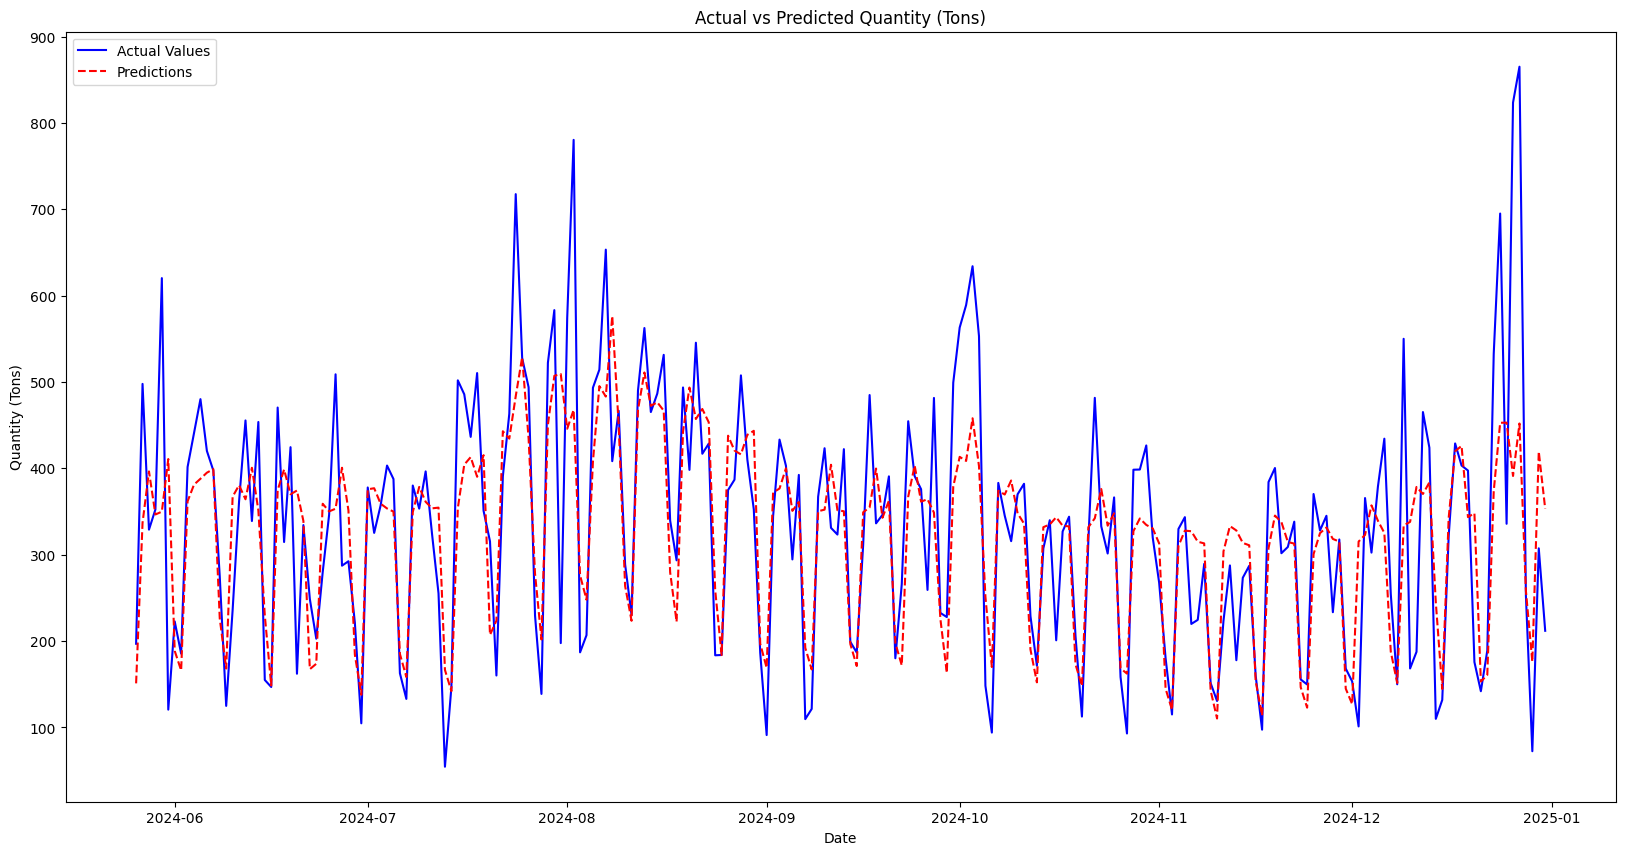

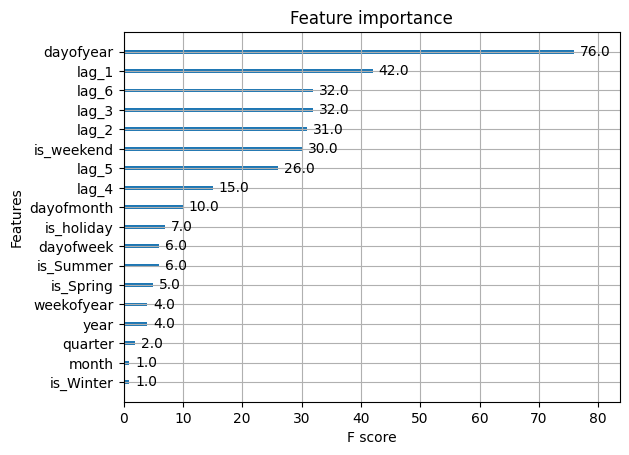

In [7]:
# train test split
split_index = int(len(feature_data) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Parameter grid for Grid Search
param_grid = {
    'n_estimators': np.arange(50,160,10),
    'learning_rate': np.arange(0.01,0.15,0.02),
    'max_depth': [1,2,3,4,5,6,7,8],
    'subsample': [1.0]
}


# Time Series Cross-Validation
#tscv = TimeSeriesSplit(n_splits=5)  # Use 5 splits for cross-validation

# Grid Search
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    #cv=tscv,
    verbose=1,
    n_jobs=-1
)

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Best parameters and RMSE
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)

# Train the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Predict and calculate RMSE
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse:.2f}')

# Plot actual vs predicted values
plt.figure(figsize=(20, 10))
plt.plot(feature_data.index[split_index:], y_test, label='Actual Values', color='blue')
plt.plot(feature_data.index[split_index:], y_pred, label='Predictions', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Quantity (Tons)')
plt.title('Actual vs Predicted Quantity (Tons)')
plt.legend()
plt.show()

# Plot feature importance
xgb.plot_importance(best_model)
plt.show()

In [12]:
# Parameter grid for Grid Search
param_grid = {
    'iterations': np.arange(50, 160, 10),  # Equivalent to n_estimators in XGBoost
    'learning_rate': np.arange(0.01, 0.15, 0.02),
    'depth': [1, 2, 3, 4, 5, 6, 7, 8],  # Equivalent to max_depth in XGBoost
    'subsample': [0.7, 0.8, 1.0]  # Similar to XGBoost
}

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)  # Use 5 splits for cross-validation

# Grid Search with TimeSeriesSplit
grid_search = GridSearchCV(
    estimator=CatBoostRegressor(loss_function='RMSE', random_state=42, verbose=0),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=tscv,  # Use TimeSeriesSplit instead of standard CV
    verbose=1,
    n_jobs=-1
)

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Best parameters and RMSE
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)

# Train the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Predict and calculate RMSE
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse:.2f}')

# Plot actual vs predicted values
plt.figure(figsize=(20, 10))
plt.plot(feature_data.index[split_index:], y_test, label='Actual Values', color='blue')
plt.plot(feature_data.index[split_index:], y_pred, label='Predictions', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Quantity (Tons)')
plt.title('Actual vs Predicted Quantity (Tons)')
plt.legend()
plt.show()

# Feature Importance plot
feature_importances = best_model.get_feature_importance()
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, tick_label=X.columns)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot')
plt.show()

Fitting 5 folds for each of 1848 candidates, totalling 9240 fits


KeyboardInterrupt: 

In [4]:
# Get unique company names
unique_companies = fetcher.waste_data['company'].unique()

# Dictionary to store DataFrames for each company
company_dfs = {}

# Process data for each company
for company in unique_companies:
    prep_data_compand = fetcher.prepare_quantity_tons_by_company(company)
    company_dfs[company] = fetcher.create_lagged_boosting_features(prep_data_compand)



Fix bc these 3 Companies are missing rows

In [5]:
# Add missing rows for CommercialServices Inc
if 'CommercialServices Inc' in company_dfs:
    first_row = company_dfs['GreenWaste Solutions'].iloc[[0]].copy()
    first_row['quantity_tons'] = 0  # Set quantity_tons to 0
    company_dfs['CommercialServices Inc'] = pd.concat([first_row, company_dfs['CommercialServices Inc']])
    company_dfs['CommercialServices Inc'] = company_dfs['CommercialServices Inc'].sort_index()

# Add missing rows for MunicipalWaste Co
if 'MunicipalWaste Co' in company_dfs:
    first_two_rows = company_dfs['GreenWaste Solutions'].iloc[[0, 1]].copy()
    first_two_rows['quantity_tons'] = 0  # Set quantity_tons to 0
    company_dfs['MunicipalWaste Co'] = pd.concat([first_two_rows, company_dfs['MunicipalWaste Co']])
    company_dfs['MunicipalWaste Co'] = company_dfs['MunicipalWaste Co'].sort_index()

# Add missing last row for Regional Waste Management
if 'RegionalWaste Management' in company_dfs:
    last_row = company_dfs['GreenWaste Solutions'].iloc[[-1]].copy()  # Get the last row
    last_row['quantity_tons'] = 0  # Set quantity_tons to 0
    company_dfs['RegionalWaste Management'] = pd.concat([company_dfs['RegionalWaste Management'], last_row])
    company_dfs['RegionalWaste Management'] = company_dfs['RegionalWaste Management'].sort_index()

In [8]:
# Example: Access the DataFrame for a specific company
example_company = list(company_dfs.keys())[2]
print(f"Data for {example_company}:")
print(company_dfs[example_company])

Data for IndustrialProcess Ltd:
            is_weekend  is_holiday  is_Fall  is_Spring  is_Summer  is_Winter  \
date                                                                           
2023-01-01         1.0         1.0      0.0        0.0        0.0        1.0   
2023-01-02         0.0         0.0      0.0        0.0        0.0        1.0   
2023-01-03         0.0         0.0      0.0        0.0        0.0        1.0   
2023-01-04         0.0         0.0      0.0        0.0        0.0        1.0   
2023-01-05         0.0         0.0      0.0        0.0        0.0        1.0   
...                ...         ...      ...        ...        ...        ...   
2024-12-27         0.0         0.0      0.0        0.0        0.0        1.0   
2024-12-28         1.0         0.0      0.0        0.0        0.0        1.0   
2024-12-29         1.0         0.0      0.0        0.0        0.0        1.0   
2024-12-30         0.0         0.0      0.0        0.0        0.0        1.0   
2024-12-

Ensemble RMSE: 71.14
Manual RMSE for 60-74 predictions: 144.08


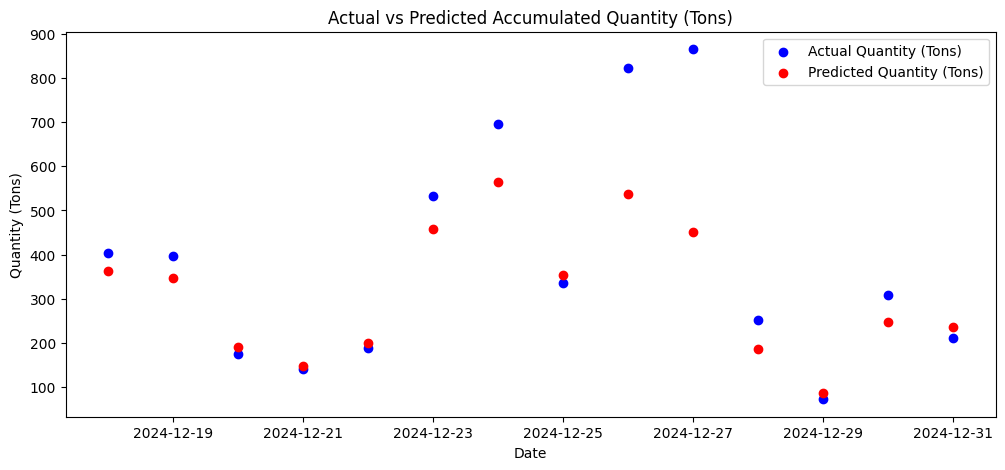

In [25]:
# Dictionary to store models and predictions
company_models = {}
company_predictions = {}



# Train models and make predictions for each company
for company, df in company_dfs.items():
    # Split data into features (X) and target (y)
    X = df.drop(columns=['quantity_tons'])
    y = df['quantity_tons']

    # Train-test split
    split_index = int(len(df) * 0.9)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    

    # Train an XGBoost model
    model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=80,
    learning_rate=0.07,
    max_depth=3,
    random_state=42
)
    model.fit(X_train, y_train)

    # Store the model
    company_models[company] = model

    # Make predictions
    y_pred = model.predict(X_test)
    #print(len(y_pred))
    company_predictions[company] = y_pred

# Aggregate predictions
total_predicted = np.sum(list(company_predictions.values()), axis=0)

# Aggregate actual values
total_actual = np.sum([company_dfs[company]['quantity_tons'][split_index:] for company in unique_companies], axis=0)



# Calculate RMSE for the ensemble
rmse = np.sqrt(mean_squared_error(total_actual, total_predicted))
print(f'Ensemble RMSE: {rmse:.2f}')

num = 60
num2 = 74
sum_squared_errors = 0

# Calculate sum of squared errors for first 7 points
for i in range(min(num, len(total_actual)),num2):
    squared_error = (total_actual[i] - total_predicted[i])**2
    sum_squared_errors += squared_error

# Calculate RMSE
rmse_7 = np.sqrt(sum_squared_errors / (num2-num))
print(f'Manual RMSE for {num}-{num2} predictions: {rmse_7:.2f}')

# Visualize actual vs predicted accumulated quantity_tons
plt.figure(figsize=(12, 5))
plt.scatter(feature_data.index[split_index+num:split_index+num2], total_actual[num:num2], label='Actual Quantity (Tons)', color='blue')
plt.scatter(feature_data.index[split_index+num:split_index+num2], total_predicted[num:num2], label='Predicted Quantity (Tons)', color='red')
plt.xlabel('Date')
plt.ylabel('Quantity (Tons)')
plt.title('Actual vs Predicted Accumulated Quantity (Tons)')
plt.legend()
plt.show()

Fitting 2 folds for each of 2520 candidates, totalling 5040 fits
Best parameters for RegionalWaste Management: {'learning_rate': 0.02, 'max_depth': 6, 'n_estimators': 80, 'subsample': 0.7}
Fitting 2 folds for each of 2520 candidates, totalling 5040 fits
Best parameters for GreenWaste Solutions: {'learning_rate': 0.09999999999999999, 'max_depth': 4, 'n_estimators': 140, 'subsample': 1.0}
Fitting 2 folds for each of 2520 candidates, totalling 5040 fits
Best parameters for IndustrialProcess Ltd: {'learning_rate': 0.04, 'max_depth': 7, 'n_estimators': 160, 'subsample': 0.8}
Fitting 2 folds for each of 2520 candidates, totalling 5040 fits
Best parameters for BuildRight Construction: {'learning_rate': 0.13, 'max_depth': 6, 'n_estimators': 160, 'subsample': 0.7}
Fitting 2 folds for each of 2520 candidates, totalling 5040 fits
Best parameters for CommercialServices Inc: {'learning_rate': 0.11, 'max_depth': 4, 'n_estimators': 160, 'subsample': 0.8}
Fitting 2 folds for each of 2520 candidates, t

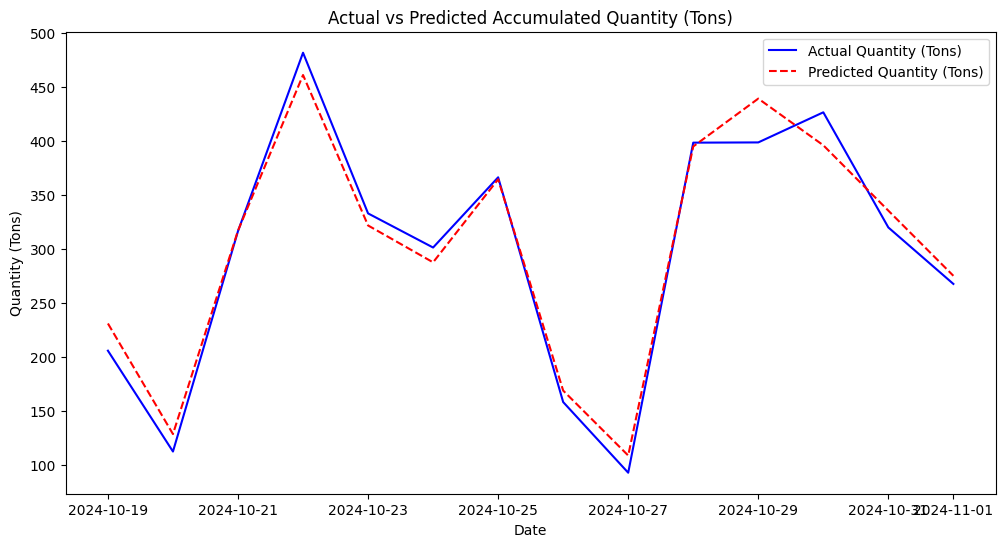

In [16]:
# Dictionary to store models and predictions
company_models = {}
company_predictions = {}

# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': np.arange(70,170,10),
    'learning_rate': np.arange(0.01,0.15,0.01),
    'max_depth': [2,3,4,5,6,7],
    'subsample': [0.7,0.8, 1.0]
}

# Train models and make predictions for each company
for company, df in company_dfs.items():
    # Split data into features (X) and target (y)
    X = df.drop(columns=['quantity_tons'])
    y = df['quantity_tons']

    # Train-test split
    split_index = int(len(df) * 0.9)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Initialize the XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

    tscv = TimeSeriesSplit(n_splits=2)  # Use 3 splits for cross-validation

    # Perform Grid Search
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',  # Use RMSE for scoring
        cv=tscv,  # 5-fold cross-validation
        verbose=1,  # Print progress
        n_jobs=-1  # Use all available CPU cores
    )
    grid_search.fit(X_train, y_train)

    # Store the best model
    best_model = grid_search.best_estimator_
    company_models[company] = best_model

    # Print the best parameters for this company
    print(f"Best parameters for {company}: {grid_search.best_params_}")

    # Make predictions with the best model
    y_pred = best_model.predict(X_test)
    company_predictions[company] = y_pred

# Aggregate predictions
total_predicted = np.sum(list(company_predictions.values()), axis=0)

# Aggregate actual values
total_actual = np.sum([company_dfs[company]['quantity_tons'][split_index:] for company in unique_companies], axis=0)

# Calculate RMSE for the ensemble
rmse = np.sqrt(mean_squared_error(total_actual, total_predicted))
print(f'Ensemble RMSE: {rmse:.2f}')

# Visualize actual vs predicted accumulated quantity_tons
plt.figure(figsize=(12, 6))
plt.plot(feature_data.index[split_index:split_index+14], total_actual[:14], label='Actual Quantity (Tons)', color='blue')
plt.plot(feature_data.index[split_index:split_index+14], total_predicted[:14], label='Predicted Quantity (Tons)', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Quantity (Tons)')
plt.title('Actual vs Predicted Accumulated Quantity (Tons)')
plt.legend()
plt.show()

In [8]:
# Dictionary to store DataFrames for each company
gru_company_dfs = {}

#  Process data for each company
for company in unique_companies:
    gru_company_dfs[company] = fetcher.prepare_quantity_tons_by_company(company)
    gru_company_dfs[company] = gru_company_dfs[company].set_index("date")

# Add missing rows for CommercialServices Inc
if 'CommercialServices Inc' in company_dfs:
    first_row = gru_company_dfs['GreenWaste Solutions'].iloc[[0]].copy()
    first_row['quantity_tons'] = 0  # Set quantity_tons to 0
    gru_company_dfs['CommercialServices Inc'] = pd.concat([first_row, gru_company_dfs['CommercialServices Inc']])
    gru_company_dfs['CommercialServices Inc'] = gru_company_dfs['CommercialServices Inc'].sort_index()

# Add missing rows for MunicipalWaste Co
if 'MunicipalWaste Co' in company_dfs:
    first_two_rows = gru_company_dfs['GreenWaste Solutions'].iloc[[0, 1]].copy()
    first_two_rows['quantity_tons'] = 0  # Set quantity_tons to 0
    gru_company_dfs['MunicipalWaste Co'] = pd.concat([first_two_rows, gru_company_dfs['MunicipalWaste Co']])
    gru_company_dfs['MunicipalWaste Co'] = gru_company_dfs['MunicipalWaste Co'].sort_index()

# Add missing last row for Regional Waste Management
if 'RegionalWaste Management' in gru_company_dfs:
    last_row = gru_company_dfs['GreenWaste Solutions'].iloc[[-1]].copy()  # Get the last row
    last_row['quantity_tons'] = 0  # Set quantity_tons to 0
    gru_company_dfs['RegionalWaste Management'] = pd.concat([gru_company_dfs['RegionalWaste Management'], last_row])
    gru_company_dfs['RegionalWaste Management'] = gru_company_dfs['RegionalWaste Management'].sort_index()

gru_company_dfs["RegionalWaste Management"]

is_weekend  is_holiday  is_Fall  is_Spring  is_Summer  is_Winter  \
date                                                                           
2022-01-01         1.0         1.0      0.0        0.0        0.0        1.0   
2022-01-02         0.0         0.0      0.0        0.0        0.0        0.0   
2022-01-03         0.0         0.0      0.0        0.0        0.0        1.0   
2022-01-04         0.0         0.0      0.0        0.0        0.0        1.0   
2022-01-05         0.0         0.0      0.0        0.0        0.0        0.0   
...                ...         ...      ...        ...        ...        ...   
2024-12-27         0.0         0.0      0.0        0.0        0.0        1.0   
2024-12-28         1.0         0.0      0.0        0.0        0.0        1.0   
2024-12-29         0.0         0.0      0.0        0.0        0.0        0.0   
2024-12-30         0.0         0.0      0.0        0.0        0.0        1.0   
2024-12-31         0.0         0.0      0.0        0.0        0.0        1.0   

            quantity_tons  
date                       
2022-01-01      51.828293  
2022-01-02       0.000000  
2022-01-03     167.399806  
2022-01-04      98.875863  
2022-01-05       0.000000  
...                   ...  
2024-12-27     244.488785  
2024-12-28     112.837616  
2024-12-29       0.000000  
2024-12-30      84.249757  
2024-12-31       0.000000  

[1096 rows x 7 columns]

GRU RMSE for RegionalWaste Management: 46.38
GRU RMSE for GreenWaste Solutions: 18.67
GRU RMSE for IndustrialProcess Ltd: 44.52
GRU RMSE for BuildRight Construction: 35.73
GRU RMSE for CommercialServices Inc: 26.77
GRU RMSE for MunicipalWaste Co: 41.18
Ensemble GRU RMSE: 133.88
Ensemble GRU RMSE for first 7 predictions: 111.12


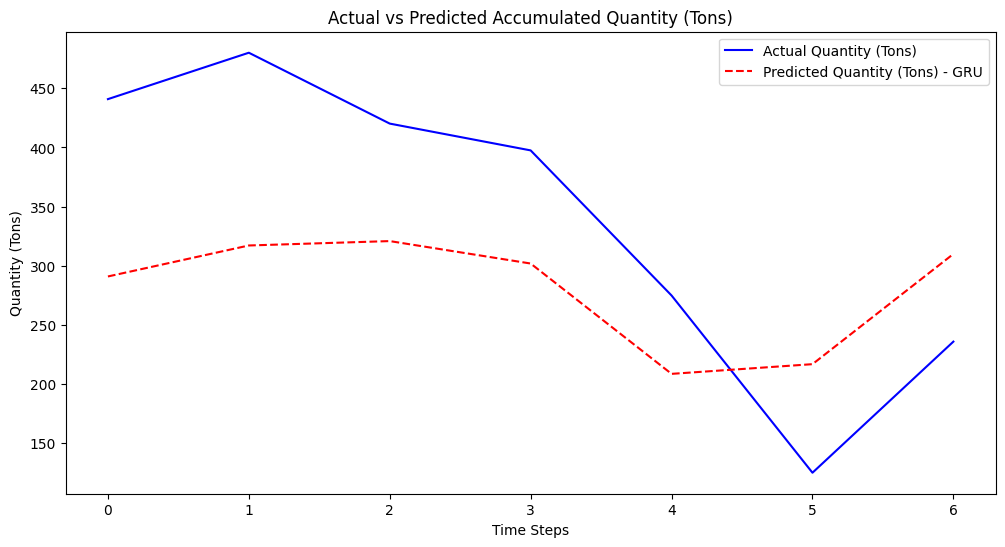

In [14]:

# Dictionary to store GRU models and predictions
gru_models = {}
gru_predictions = {}

# Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:i + seq_length]  # All features for sequence
        y = data.iloc[i + seq_length]['quantity_tons']  # Only quantity_tons as target
        xs.append(x.values)
        ys.append([y])  # Wrap in list to maintain dimensionality
    return np.array(xs), np.array(ys)

# Define GRU model in PyTorch
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Train and evaluate GRU models for each company
seq_length = 7  # Sequence length
input_size = gru_company_dfs["RegionalWaste Management"].shape[1]  # Number of features
hidden_size = 70  # Number of hidden units
output_size = 1  # Number of output features (quantity_tons)

for company, df in gru_company_dfs.items():
    # Create sequences
    X, y = create_sequences(df, seq_length)

    # Split into training and testing sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    # Create DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Initialize GRU model
    gru_model = GRUModel(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.001)

    # Train GRU model
    num_epochs = 50
    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            # Forward pass
            outputs = gru_model(batch_X)
            loss = criterion(outputs, batch_y)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Store the trained model
    gru_models[company] = gru_model

    # Make predictions
    gru_model.eval()
    with torch.no_grad():
        y_pred = gru_model(X_test).numpy()
    gru_predictions[company] = y_pred.flatten()

    # Calculate RMSE for this company
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"GRU RMSE for {company}: {rmse:.2f}")

# Aggregate predictions from all companies
total_predicted = np.sum(list(gru_predictions.values()), axis=0)

# Aggregate actual values for all companies
total_actual = np.sum([df['quantity_tons'][train_size + seq_length:] for df in gru_company_dfs.values()], axis=0)

# Calculate RMSE for the ensemble
ensemble_rmse = np.sqrt(mean_squared_error(total_actual, total_predicted))
print(f'Ensemble GRU RMSE: {ensemble_rmse:.2f}')

# Calculate RMSE for the first 7 predictions of the ensemble

sum_squared_errors = 0
count = 0

# Use only the first 7 values (or fewer if arrays are shorter)
for i in range(min(num, len(total_actual), len(total_predicted)), num2):
    # Skip NaN values
    if np.isnan(total_actual[i]) or np.isnan(total_predicted[i]):
        continue
        
    squared_error = (total_actual[i] - total_predicted[i])**2
    sum_squared_errors += squared_error
    count += 1

# Calculate RMSE
if count > 0:
    ensemble_rmse_7 = np.sqrt(sum_squared_errors / count)
    print(f'Ensemble GRU RMSE for first {count} predictions: {ensemble_rmse_7:.2f}')
else:
    print(f"Cannot calculate Ensemble RMSE: No valid data points in first {num} values")


# Visualize actual vs predicted accumulated quantity_tons
plt.figure(figsize=(12, 6))
plt.plot(total_actual[num:num2], label='Actual Quantity (Tons)', color='blue')
plt.plot(total_predicted[num:num2], label='Predicted Quantity (Tons) - GRU', color='red', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Quantity (Tons)')
plt.title('Actual vs Predicted Accumulated Quantity (Tons)')
plt.legend()
plt.show()


LSTM RMSE for RegionalWaste Management: 37.63
LSTM RMSE for GreenWaste Solutions: 17.40
LSTM RMSE for IndustrialProcess Ltd: 43.98
LSTM RMSE for BuildRight Construction: 35.95
LSTM RMSE for CommercialServices Inc: 25.58
LSTM RMSE for MunicipalWaste Co: 33.74
Ensemble LSTM RMSE: 108.88
Ensemble LSTM RMSE for predictions 0 to 61: 94.55


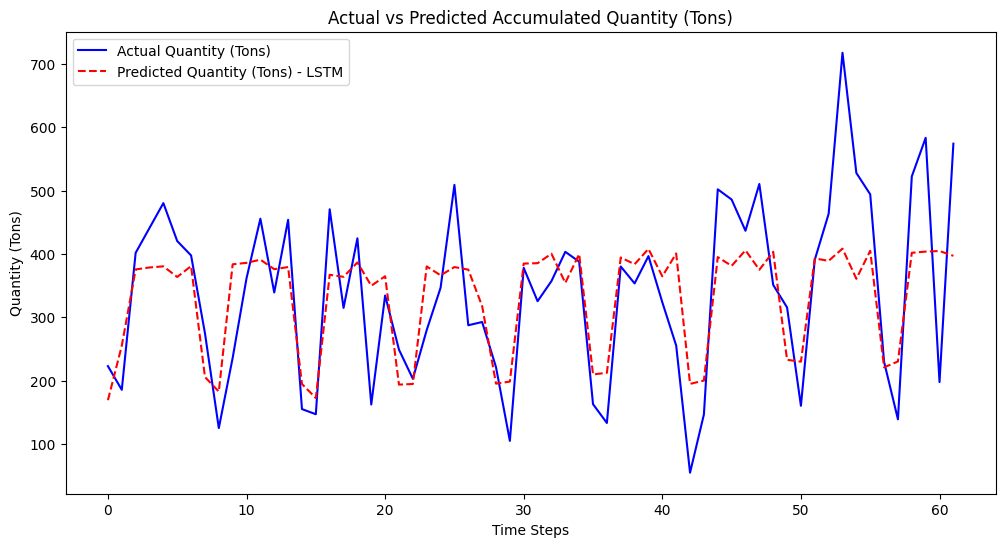

In [41]:
# Dictionary to store LSTM models and predictions
lstm_models = {}
lstm_predictions = {}

# Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:i + seq_length]  # All features for sequence
        y = data.iloc[i + seq_length]['quantity_tons']  # Only quantity_tons as target
        xs.append(x.values)
        ys.append([y])  # Wrap in list to maintain dimensionality
    return np.array(xs), np.array(ys)

# Define LSTM model in PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Train and evaluate LSTM models for each company
seq_length = 28  # Sequence length
input_size = gru_company_dfs["RegionalWaste Management"].shape[1]  # Number of features
hidden_size = 70  # Number of hidden units
output_size = 1  # Number of output features (quantity_tons)

for company, df in gru_company_dfs.items():
    # Create sequences
    X, y = create_sequences(df, seq_length)

    # Split into training and testing sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    # Create DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

    # Initialize LSTM model
    lstm_model = LSTMModel(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

    # Train LSTM model
    num_epochs = 85
    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            # Forward pass
            outputs = lstm_model(batch_X)
            loss = criterion(outputs, batch_y)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Store the trained model
    lstm_models[company] = lstm_model

    # Make predictions
    lstm_model.eval()
    with torch.no_grad():
        y_pred = lstm_model(X_test).numpy()
    lstm_predictions[company] = y_pred.flatten()

    # Calculate RMSE for this company
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"LSTM RMSE for {company}: {rmse:.2f}")

# Aggregate predictions from all companies
total_predicted = np.sum(list(lstm_predictions.values()), axis=0)

# Aggregate actual values for all companies
total_actual = np.sum([df['quantity_tons'][train_size + seq_length:] for df in gru_company_dfs.values()], axis=0)

# Calculate RMSE for the ensemble
ensemble_rmse = np.sqrt(mean_squared_error(total_actual, total_predicted))
print(f'Ensemble LSTM RMSE: {ensemble_rmse:.2f}')

# Make sure these variables are defined
num = 0  # Starting index
num2 = 62  # Ending index (adjust as needed)

# Calculate RMSE for a specific range of predictions
sum_squared_errors = 0
count = 0

# Use the specified range
for i in range(num, min(num2, len(total_actual), len(total_predicted))):
    # Skip NaN values
    if np.isnan(total_actual[i]) or np.isnan(total_predicted[i]):
        continue
        
    squared_error = (total_actual[i] - total_predicted[i])**2
    sum_squared_errors += squared_error
    count += 1

# Calculate RMSE
if count > 0:
    ensemble_rmse_range = np.sqrt(sum_squared_errors / count)
    print(f'Ensemble LSTM RMSE for predictions {num} to {num2-1}: {ensemble_rmse_range:.2f}')
else:
    print(f"Cannot calculate Ensemble RMSE: No valid data points in range {num} to {num2-1}")

# Visualize actual vs predicted accumulated quantity_tons
plt.figure(figsize=(12, 6))
plt.plot(total_actual[num:num2], label='Actual Quantity (Tons)', color='blue')
plt.plot(total_predicted[num:num2], label='Predicted Quantity (Tons) - LSTM', color='red', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Quantity (Tons)')
plt.title('Actual vs Predicted Accumulated Quantity (Tons)')
plt.legend()
plt.show()

In [10]:
for company, df in gru_company_dfs.items():
    print(f"{company} - NaN count in quantity_tons: {df['quantity_tons'].isna().sum()}")

RegionalWaste Management - NaN count in quantity_tons: 0
GreenWaste Solutions - NaN count in quantity_tons: 0
IndustrialProcess Ltd - NaN count in quantity_tons: 0
BuildRight Construction - NaN count in quantity_tons: 0
CommercialServices Inc - NaN count in quantity_tons: 0
MunicipalWaste Co - NaN count in quantity_tons: 0


01:08:16 - cmdstanpy - INFO - Chain [1] start processing



--- Processing RegionalWaste Management ---

Data for RegionalWaste Management:
Original first 3 values: [ 51.82829298   0.         167.39980577]
Transferred first 3 values: [ 51.82829298   0.         167.39980577]
NaN count in original: 0
NaN count in new df: 0
Training data shape: (876, 8)
Test data shape: (220, 8)


01:08:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE for RegionalWaste Management: 31.92


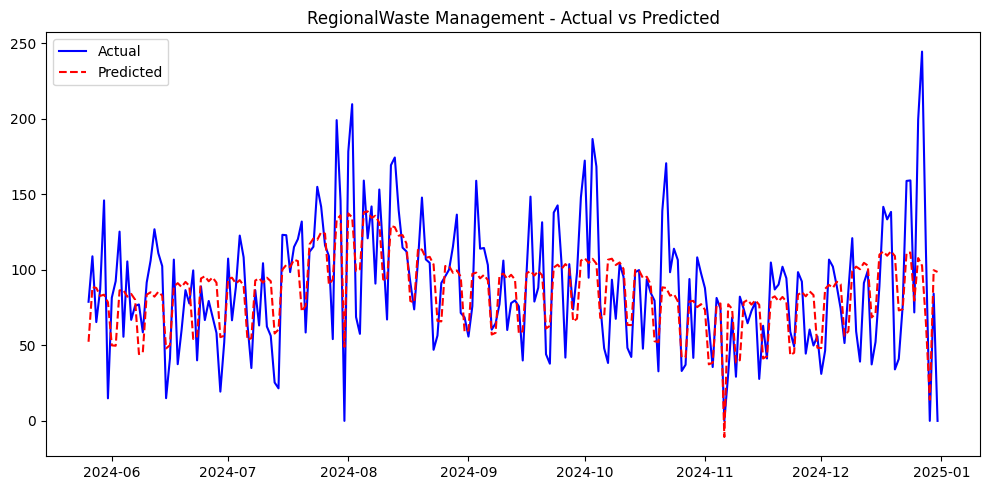


--- Processing GreenWaste Solutions ---

Data for GreenWaste Solutions:
Original first 3 values: [ 8.73102334 19.19086704 41.6481167 ]
Transferred first 3 values: [ 8.73102334 19.19086704 41.6481167 ]
NaN count in original: 0
NaN count in new df: 0
Training data shape: (876, 8)
Test data shape: (220, 8)


01:08:17 - cmdstanpy - INFO - Chain [1] start processing
01:08:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE for GreenWaste Solutions: 13.02


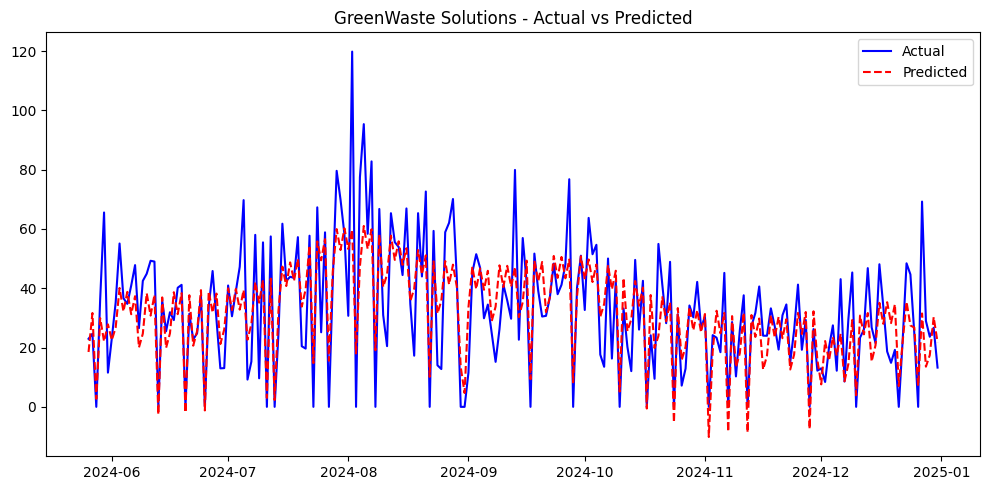


--- Processing IndustrialProcess Ltd ---

Data for IndustrialProcess Ltd:
Original first 3 values: [ 80.97550717 117.60678942 141.70334477]
Transferred first 3 values: [ 80.97550717 117.60678942 141.70334477]
NaN count in original: 0
NaN count in new df: 0
Training data shape: (876, 8)
Test data shape: (220, 8)


01:08:17 - cmdstanpy - INFO - Chain [1] start processing
01:08:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE for IndustrialProcess Ltd: 26.68


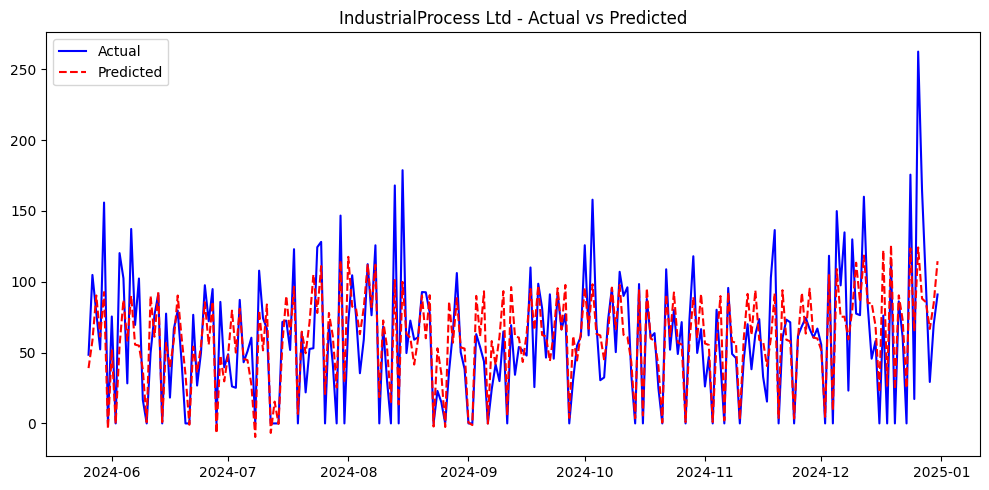


--- Processing BuildRight Construction ---

Data for BuildRight Construction:
Original first 3 values: [12.31667987 35.09618915 42.85189942]
Transferred first 3 values: [12.31667987 35.09618915 42.85189942]
NaN count in original: 0
NaN count in new df: 0
Training data shape: (876, 8)
Test data shape: (220, 8)


01:08:18 - cmdstanpy - INFO - Chain [1] start processing
01:08:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE for BuildRight Construction: 25.99


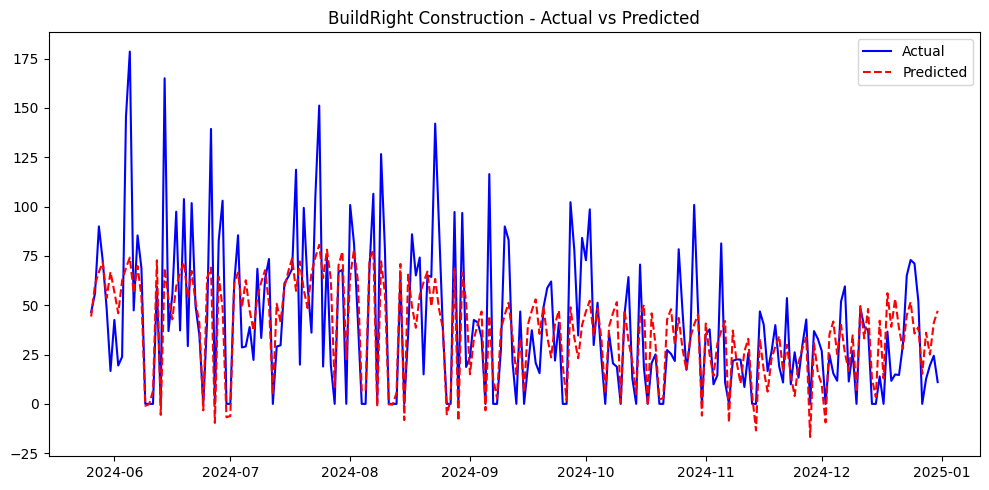


--- Processing CommercialServices Inc ---

Data for CommercialServices Inc:
Original first 3 values: [ 0.         73.95243233 84.8513772 ]
Transferred first 3 values: [ 0.         73.95243233 84.8513772 ]
NaN count in original: 0
NaN count in new df: 0
Training data shape: (876, 8)
Test data shape: (220, 8)


01:08:18 - cmdstanpy - INFO - Chain [1] start processing
01:08:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE for CommercialServices Inc: 19.63


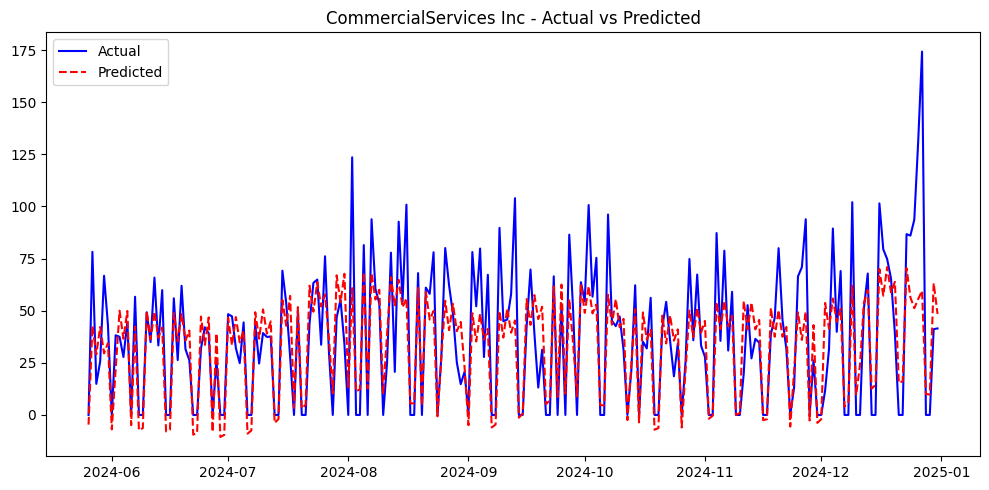


--- Processing MunicipalWaste Co ---

Data for MunicipalWaste Co:
Original first 3 values: [ 0.          0.         95.68523062]
Transferred first 3 values: [ 0.          0.         95.68523062]
NaN count in original: 0
NaN count in new df: 0
Training data shape: (876, 8)
Test data shape: (220, 8)


01:08:19 - cmdstanpy - INFO - Chain [1] start processing
01:08:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE for MunicipalWaste Co: 27.52


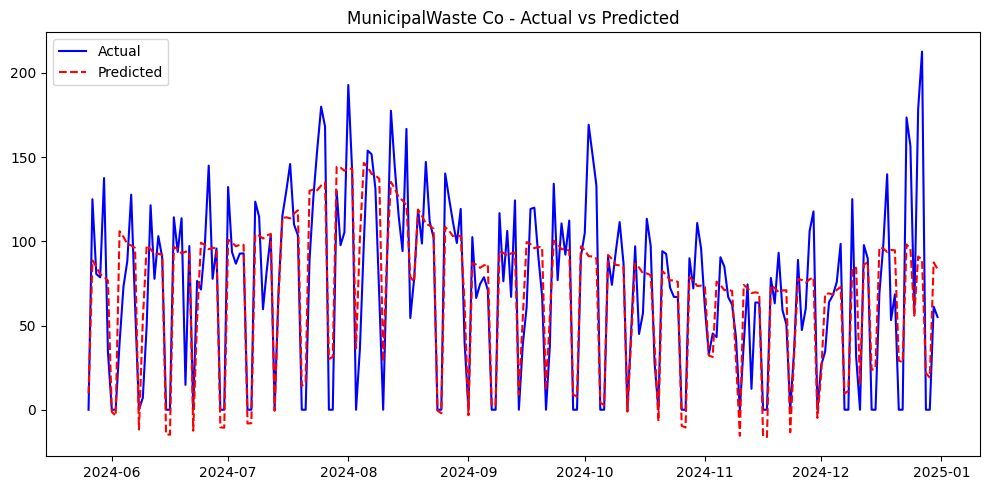


Data for RegionalWaste Management:
Original first 3 values: [ 51.82829298   0.         167.39980577]
Transferred first 3 values: [ 51.82829298   0.         167.39980577]
NaN count in original: 0
NaN count in new df: 0

Data for GreenWaste Solutions:
Original first 3 values: [ 8.73102334 19.19086704 41.6481167 ]
Transferred first 3 values: [ 8.73102334 19.19086704 41.6481167 ]
NaN count in original: 0
NaN count in new df: 0

Data for IndustrialProcess Ltd:
Original first 3 values: [ 80.97550717 117.60678942 141.70334477]
Transferred first 3 values: [ 80.97550717 117.60678942 141.70334477]
NaN count in original: 0
NaN count in new df: 0

Data for BuildRight Construction:
Original first 3 values: [12.31667987 35.09618915 42.85189942]
Transferred first 3 values: [12.31667987 35.09618915 42.85189942]
NaN count in original: 0
NaN count in new df: 0

Data for CommercialServices Inc:
Original first 3 values: [ 0.         73.95243233 84.8513772 ]
Transferred first 3 values: [ 0.         73.952

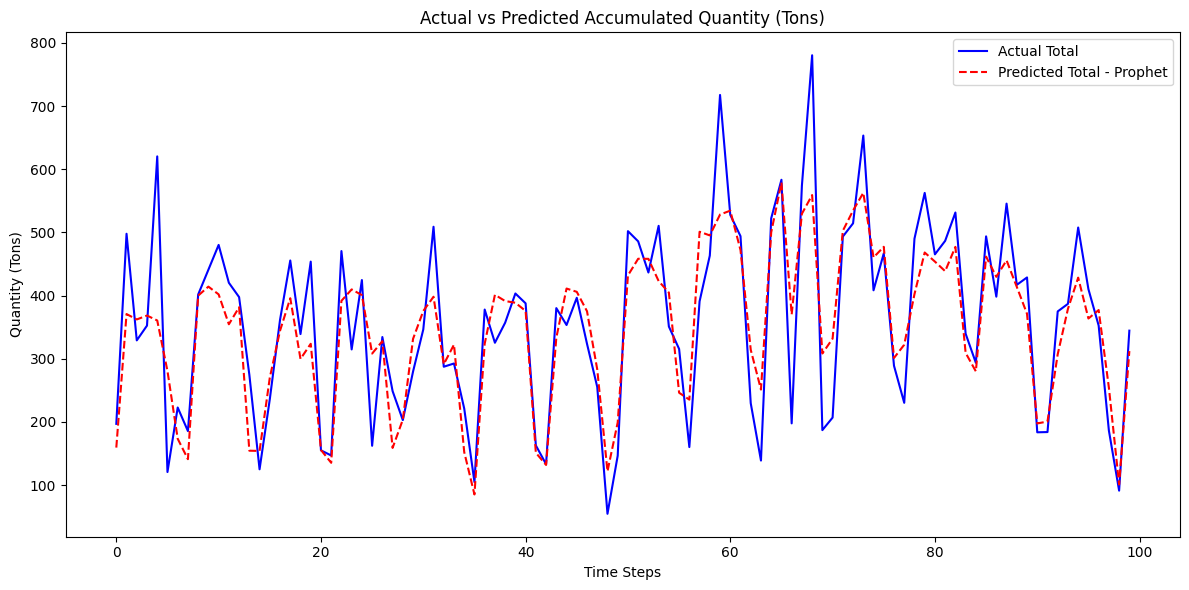

<Figure size 1200x1000 with 0 Axes>

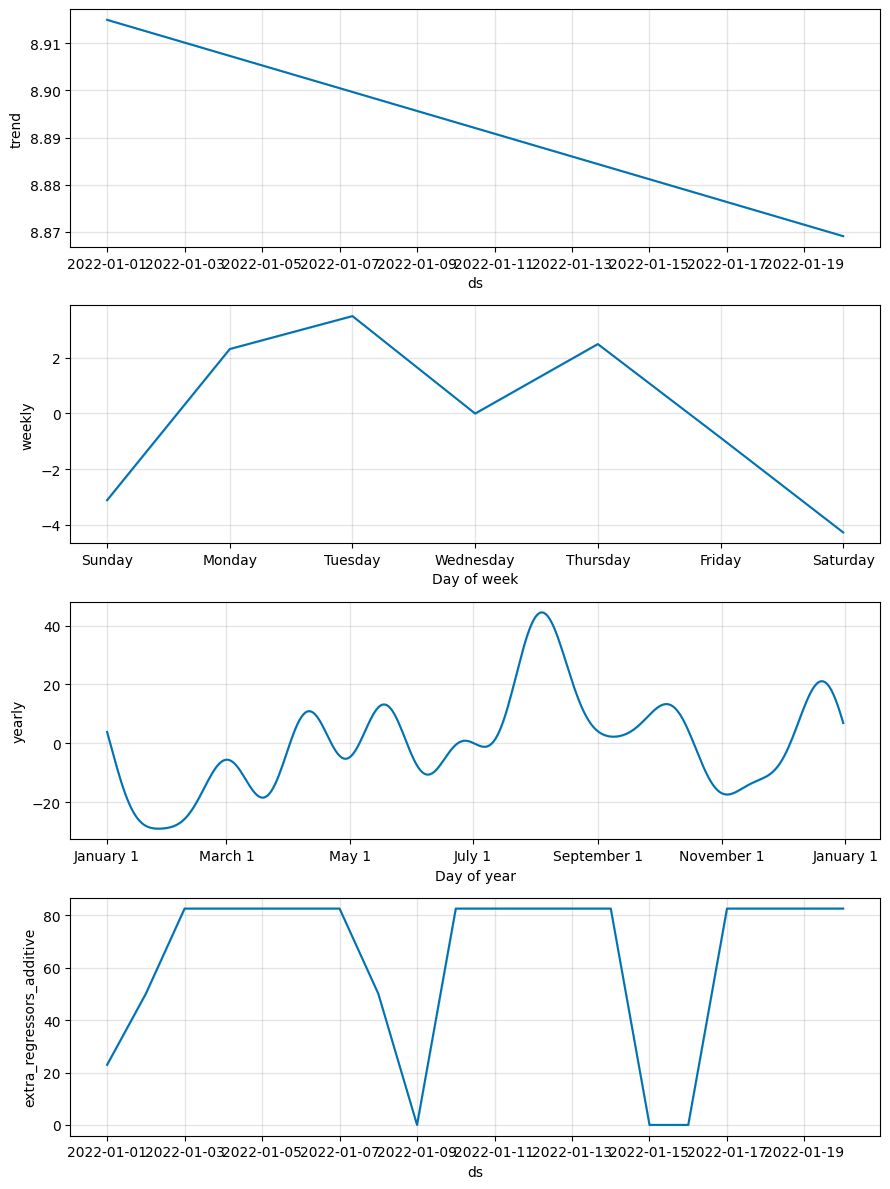

In [14]:
# Dictionary to store Prophet models and predictions
prophet_models = {}
prophet_predictions = {}

# Import necessary libraries if not already imported
from prophet import Prophet


# Function to properly prepare data for Prophet
def prepare_prophet_data(data, company_name, target_col='quantity_tons'):
    """
    Prepare data for Prophet with correct data transfer
    """
    # Create a new DataFrame with explicit copying of data
    prophet_df = pd.DataFrame()
    
    # Copy the DatetimeIndex to the ds column
    if isinstance(data.index, pd.DatetimeIndex):
        prophet_df['ds'] = data.index.copy()
    else:
        prophet_df['ds'] = pd.date_range(start='2022-01-01', periods=len(data), freq='D')
    
    # CRITICAL FIX: Explicitly copy the target column values
    # The issue was in how the data was being transferred
    prophet_df['y'] = data[target_col].values.copy()
    
    # Debug information
    print(f"\nData for {company_name}:")
    print(f"Original first 3 values: {data[target_col].head(3).values}")
    print(f"Transferred first 3 values: {prophet_df['y'].head(3).values}")
    print(f"NaN count in original: {data[target_col].isna().sum()}")
    print(f"NaN count in new df: {prophet_df['y'].isna().sum()}")
    
    # Add regressor columns
    for col in data.columns:
        if col != target_col:
            prophet_df[col] = data[col].values.copy()
    
    # Verify data is valid
    if prophet_df['y'].isna().all():
        raise ValueError(f"All target values are NaN for {company_name}")
    
    return prophet_df

# Train and evaluate Prophet models for each company
for company, df in gru_company_dfs.items():
    print(f"\n--- Processing {company} ---")
    
    try:
        # Prepare data for Prophet
        prophet_df = prepare_prophet_data(df, company)
        
        # Split into training and testing sets
        train_size = int(len(prophet_df) * 0.8)
        train_df = prophet_df.iloc[:train_size].copy()
        test_df = prophet_df.iloc[train_size:].copy()
        
        print(f"Training data shape: {train_df.shape}")
        print(f"Test data shape: {test_df.shape}")
        
        # Create Prophet model with simple configuration
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            seasonality_mode='additive'
        )
        
        # Add regressors
        for col in df.columns:
            if col != 'quantity_tons':
                model.add_regressor(col)
        
        # Fit model
        model.fit(train_df)
        
        # Store the trained model
        prophet_models[company] = model
        
        # Create future dataframe for predictions
        future = pd.concat([train_df, test_df])
        
        # Make predictions
        forecast = model.predict(future)
        
        # Extract relevant predictions for test period
        test_predictions = forecast.iloc[train_size:]['yhat'].values
        prophet_predictions[company] = test_predictions
        
        # Calculate RMSE for this company
        actual = test_df['y'].values
        rmse = np.sqrt(mean_squared_error(actual, test_predictions))
        print(f"Prophet RMSE for {company}: {rmse:.2f}")
        
        # Visualize predictions for this company
        plt.figure(figsize=(10, 5))
        plt.plot(test_df['ds'], test_df['y'], 'b-', label='Actual')
        plt.plot(test_df['ds'], test_predictions, 'r--', label='Predicted')
        plt.title(f'{company} - Actual vs Predicted')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error processing {company}: {str(e)}")
        continue

# Proceed with ensemble metrics if we have successful predictions
if prophet_predictions:
    # Ensure all prediction arrays are the same length
    min_length = min(len(preds) for preds in prophet_predictions.values())
    
    # Normalize predictions to the same length
    aligned_predictions = {company: preds[:min_length] for company, preds in prophet_predictions.items()}
    
    # Aggregate predictions from all companies
    total_predicted = np.sum(list(aligned_predictions.values()), axis=0)
    
    # Get test data for actual values
    successful_companies = list(prophet_predictions.keys())
    actual_values = []
    
    for company in successful_companies:
        prophet_df = prepare_prophet_data(gru_company_dfs[company], company)
        train_size = int(len(prophet_df) * 0.8)
        company_actual = prophet_df['y'].values[train_size:train_size+min_length]
        actual_values.append(company_actual)
    
    total_actual = np.sum(actual_values, axis=0)
    
    # Calculate RMSE for the ensemble
    ensemble_rmse = np.sqrt(mean_squared_error(total_actual, total_predicted))
    print(f'\nEnsemble Prophet RMSE: {ensemble_rmse:.2f}')
    
    # Define the range for evaluation (similar to your LSTM code)
    num = 0  # Starting index
    num2 = min(100, len(total_actual))  # Ending index
    
    # Calculate RMSE for a specific range
    range_rmse = np.sqrt(mean_squared_error(total_actual[num:num2], total_predicted[num:num2]))
    print(f'Ensemble Prophet RMSE for predictions {num} to {num2-1}: {range_rmse:.2f}')
    
    # Visualize ensemble results
    plt.figure(figsize=(12, 6))
    plt.plot(total_actual[num:num2], label='Actual Total', color='blue')
    plt.plot(total_predicted[num:num2], label='Predicted Total - Prophet', color='red', linestyle='--')
    plt.xlabel('Time Steps')
    plt.ylabel('Quantity (Tons)')
    plt.title('Actual vs Predicted Accumulated Quantity (Tons)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Optional: Compare with components analysis
    plt.figure(figsize=(12, 10))
    model = prophet_models[list(prophet_models.keys())[0]]  # Use first company model
    fig = model.plot_components(model.predict(future.iloc[:20]))
    plt.tight_layout()
    plt.show()
else:
    print("No successful predictions. Check the errors above.")

01:10:32 - cmdstanpy - INFO - Chain [1] start processing



--- Processing RegionalWaste Management ---

Data for RegionalWaste Management:
Original first 3 values: [ 51.82829298   0.         167.39980577]
Transferred first 3 values: [ 51.82829298   0.         167.39980577]
NaN count in original: 0
NaN count in new df: 0
Training data shape: (876, 12)
Test data shape: (220, 12)


01:10:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE for RegionalWaste Management: 32.36


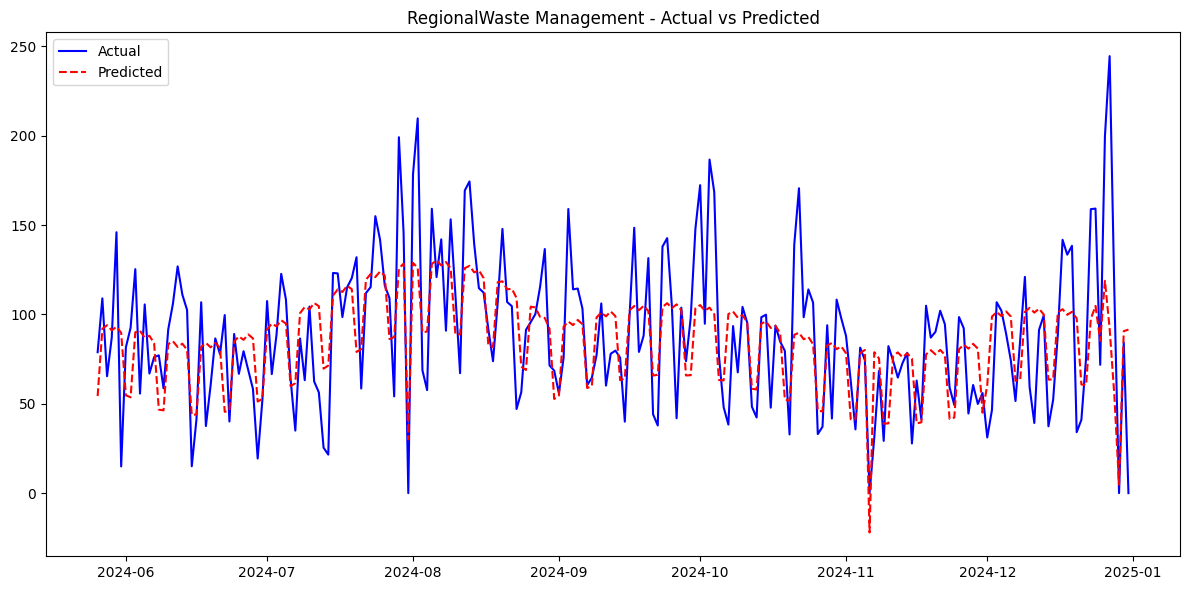

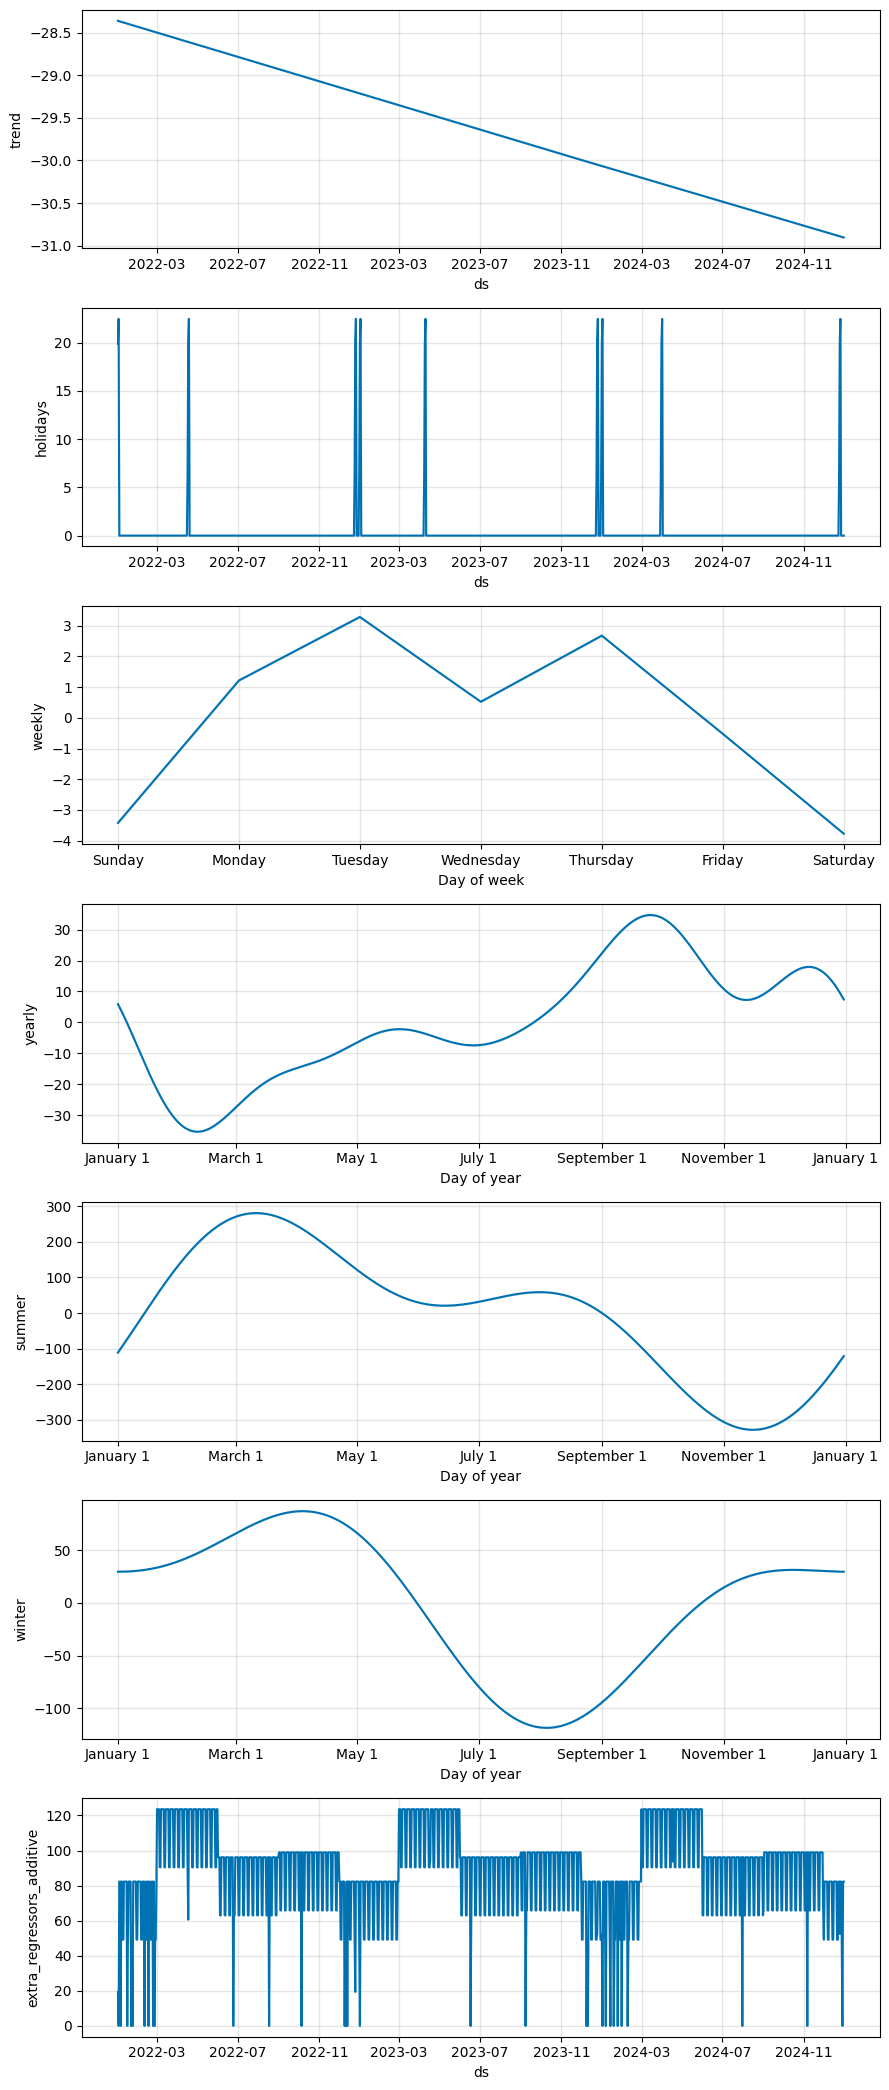

01:10:34 - cmdstanpy - INFO - Chain [1] start processing



--- Processing GreenWaste Solutions ---

Data for GreenWaste Solutions:
Original first 3 values: [ 8.73102334 19.19086704 41.6481167 ]
Transferred first 3 values: [ 8.73102334 19.19086704 41.6481167 ]
NaN count in original: 0
NaN count in new df: 0
Training data shape: (876, 12)
Test data shape: (220, 12)


01:10:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE for GreenWaste Solutions: 13.26


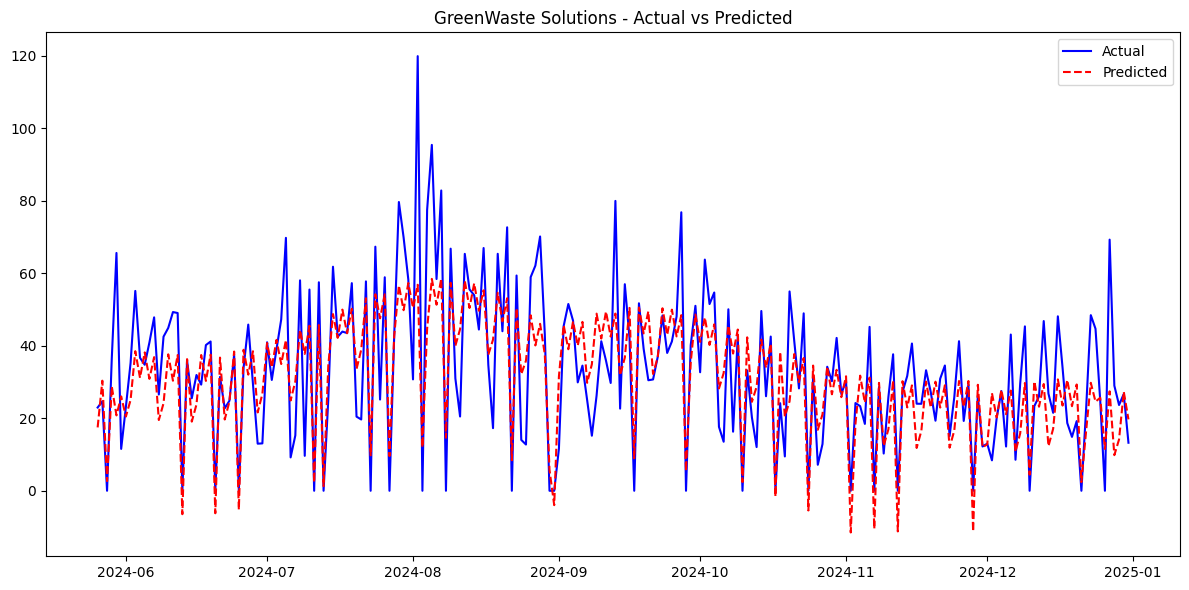

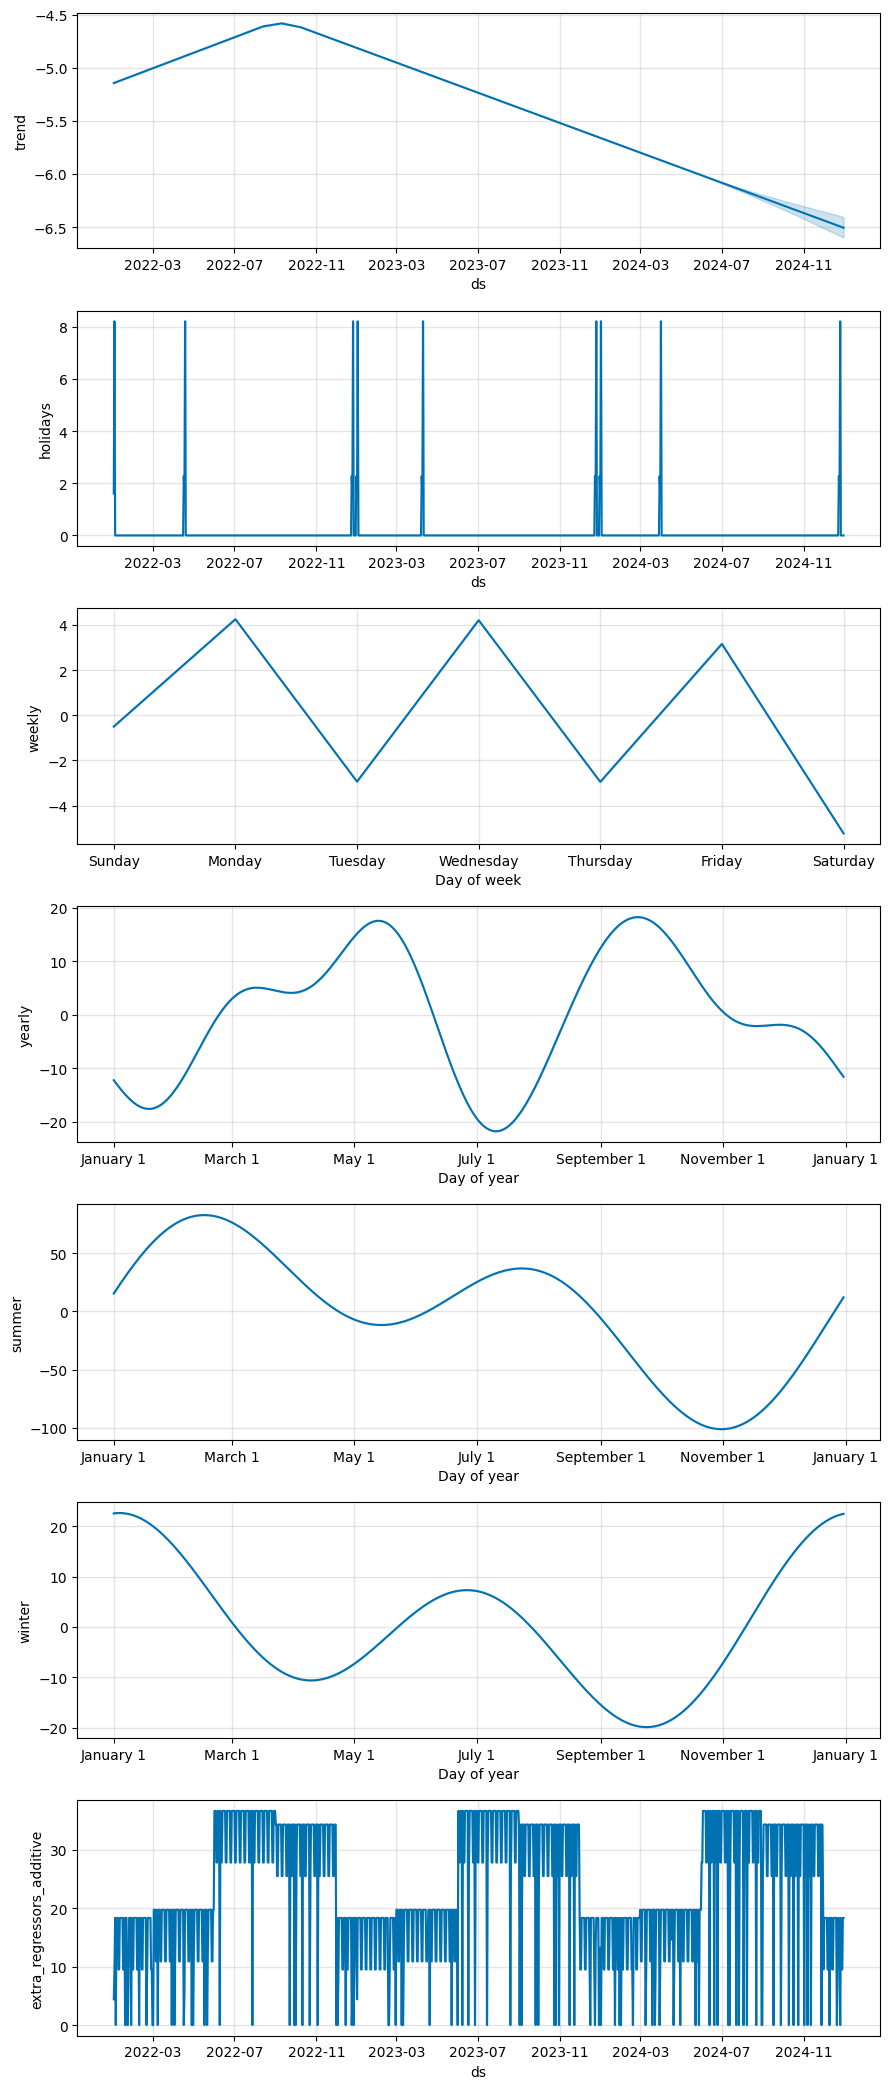


--- Processing IndustrialProcess Ltd ---

Data for IndustrialProcess Ltd:
Original first 3 values: [ 80.97550717 117.60678942 141.70334477]
Transferred first 3 values: [ 80.97550717 117.60678942 141.70334477]
NaN count in original: 0
NaN count in new df: 0
Training data shape: (876, 12)
Test data shape: (220, 12)


01:10:36 - cmdstanpy - INFO - Chain [1] start processing
01:10:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE for IndustrialProcess Ltd: 26.58


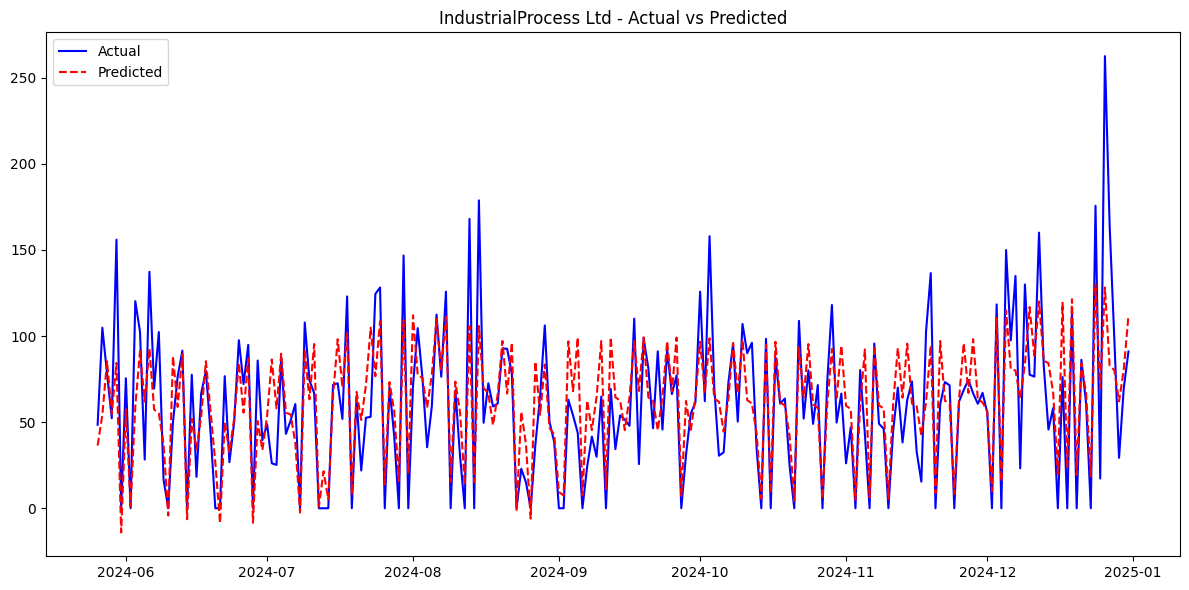

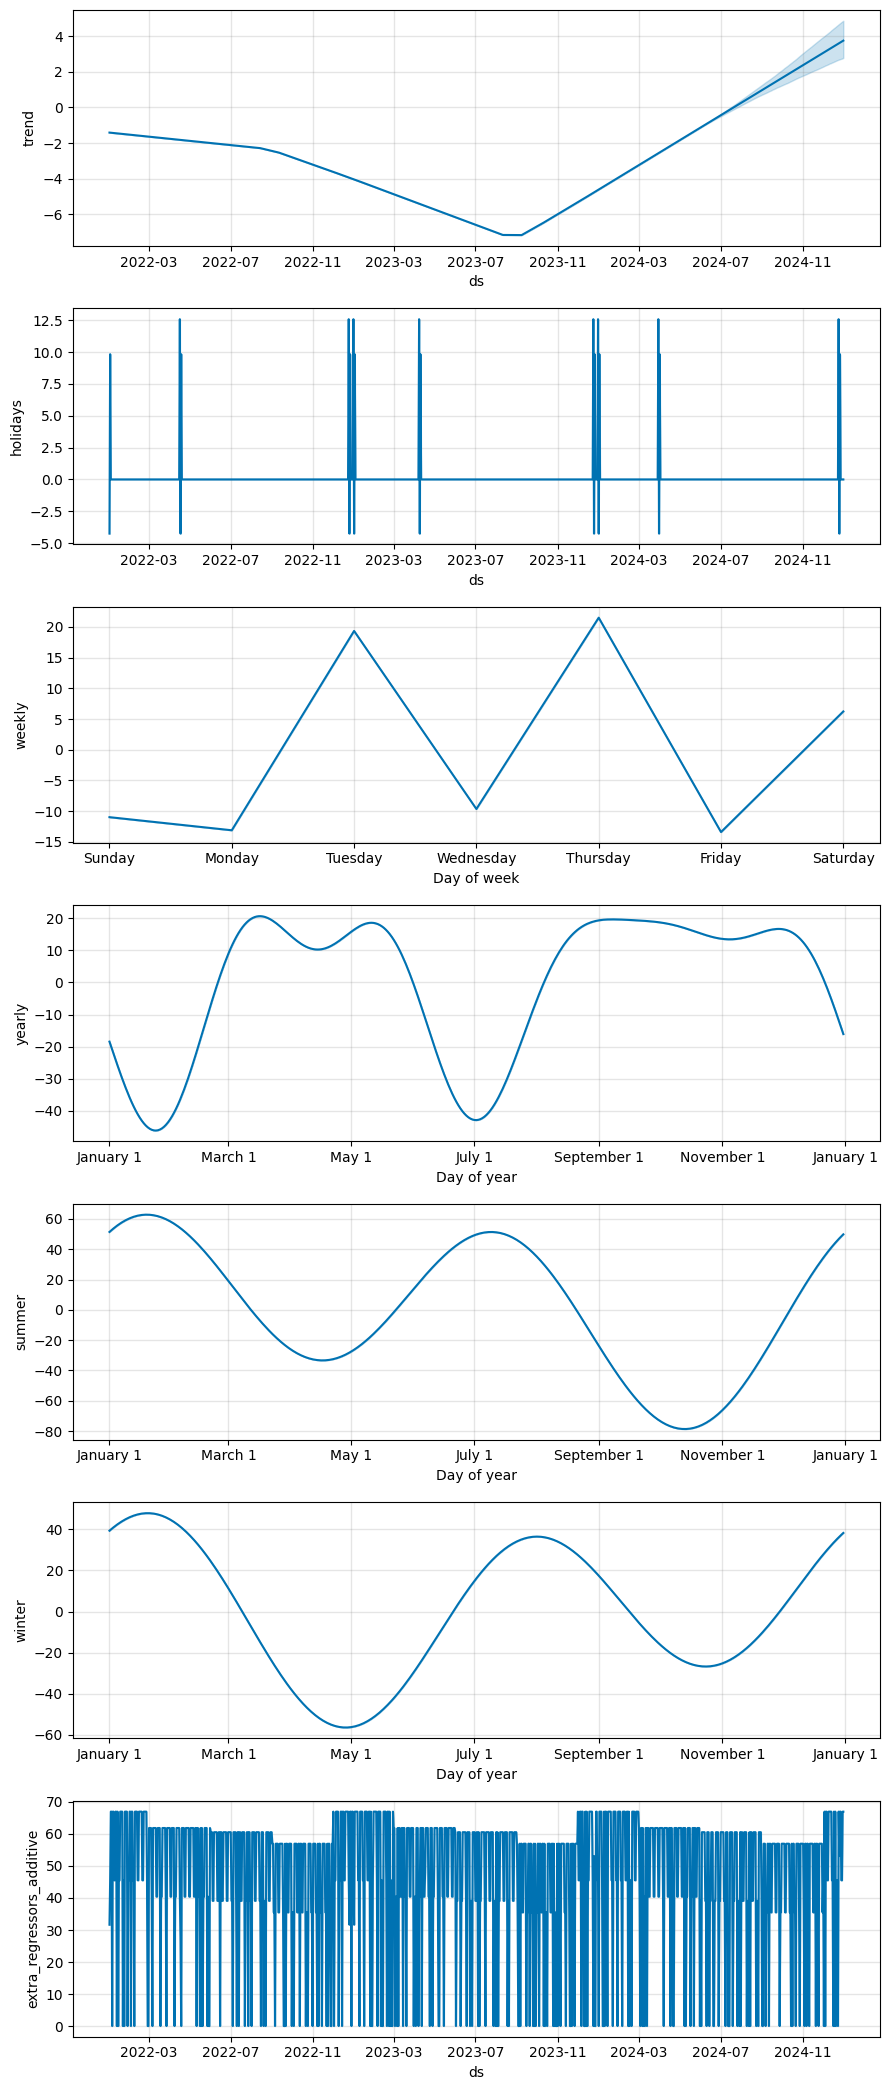

01:10:37 - cmdstanpy - INFO - Chain [1] start processing



--- Processing BuildRight Construction ---

Data for BuildRight Construction:
Original first 3 values: [12.31667987 35.09618915 42.85189942]
Transferred first 3 values: [12.31667987 35.09618915 42.85189942]
NaN count in original: 0
NaN count in new df: 0
Training data shape: (876, 12)
Test data shape: (220, 12)


01:10:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE for BuildRight Construction: 25.96


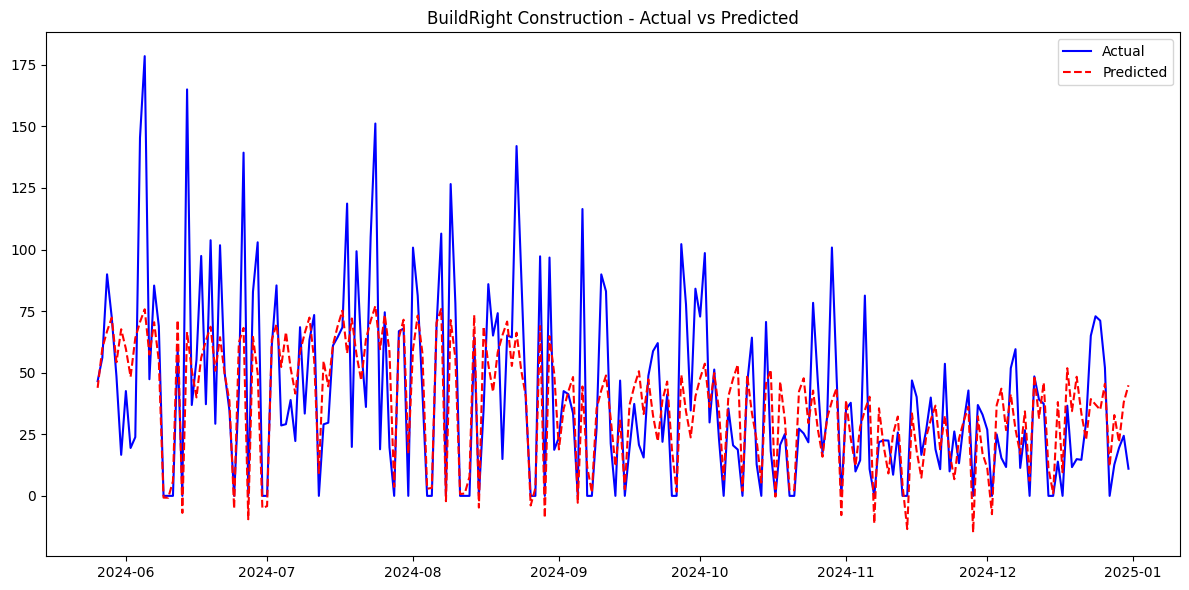

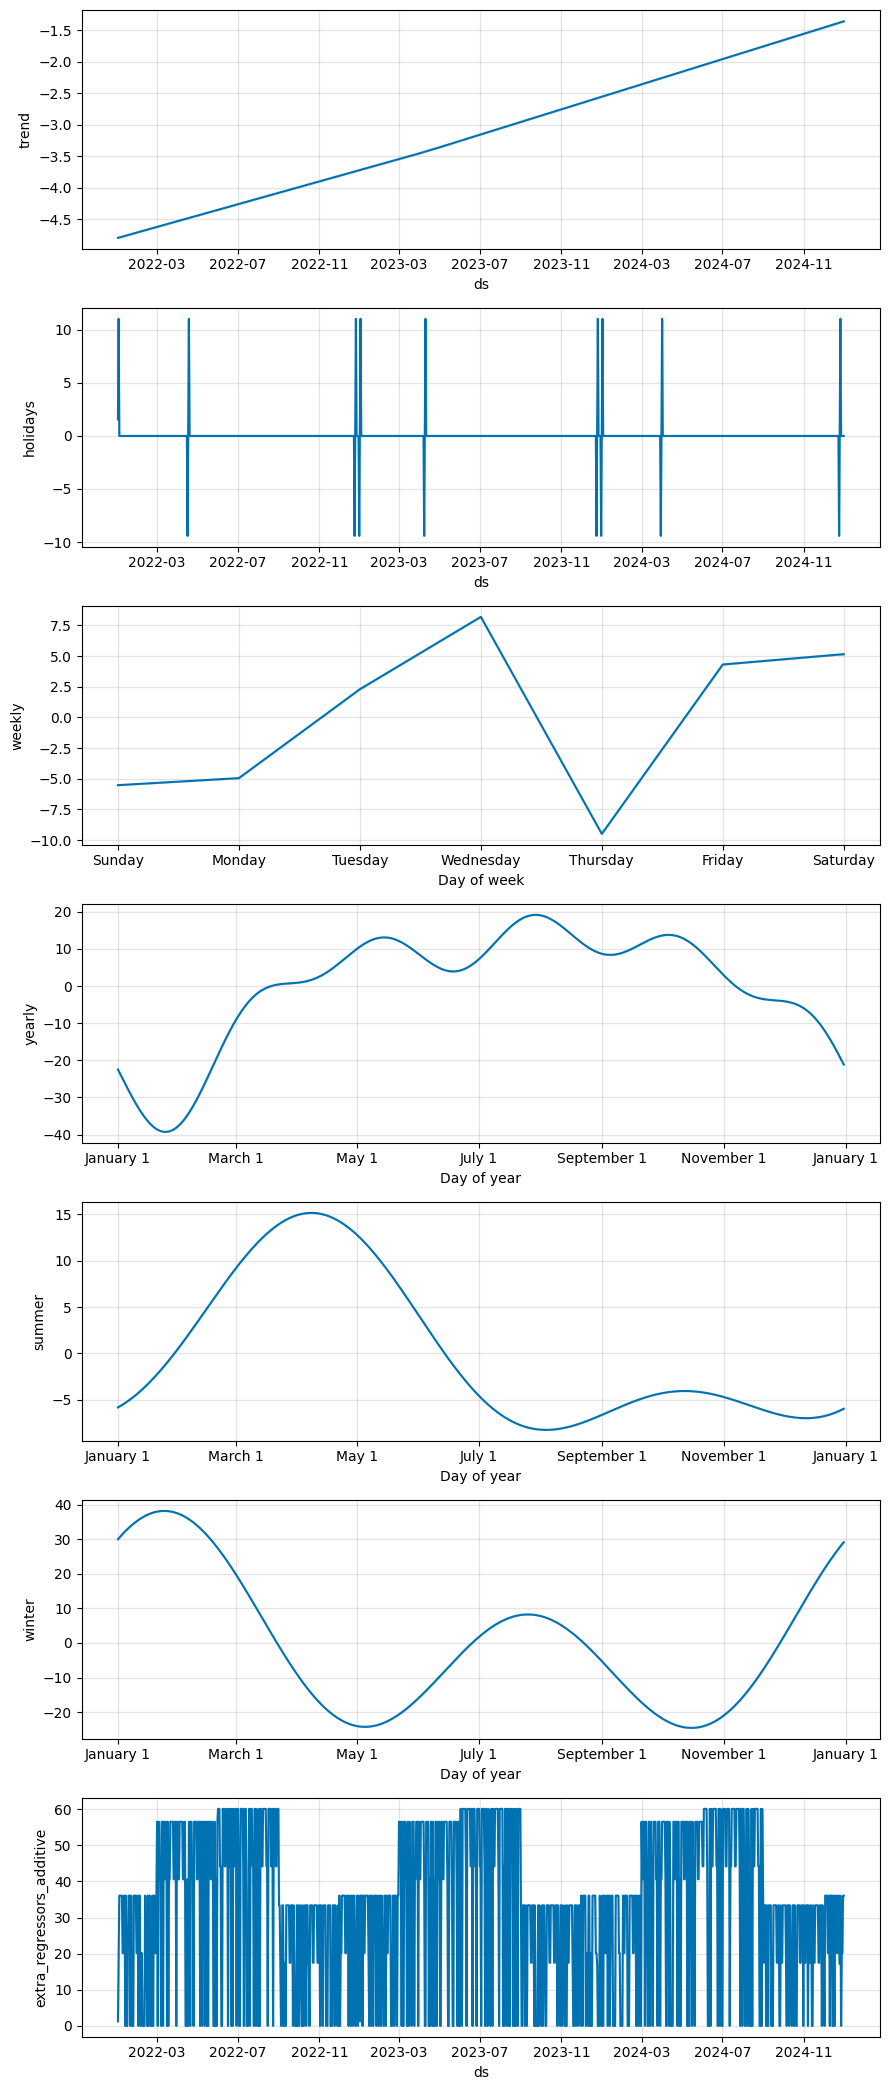

01:10:39 - cmdstanpy - INFO - Chain [1] start processing



--- Processing CommercialServices Inc ---

Data for CommercialServices Inc:
Original first 3 values: [ 0.         73.95243233 84.8513772 ]
Transferred first 3 values: [ 0.         73.95243233 84.8513772 ]
NaN count in original: 0
NaN count in new df: 0
Training data shape: (876, 12)
Test data shape: (220, 12)


01:10:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE for CommercialServices Inc: 20.00


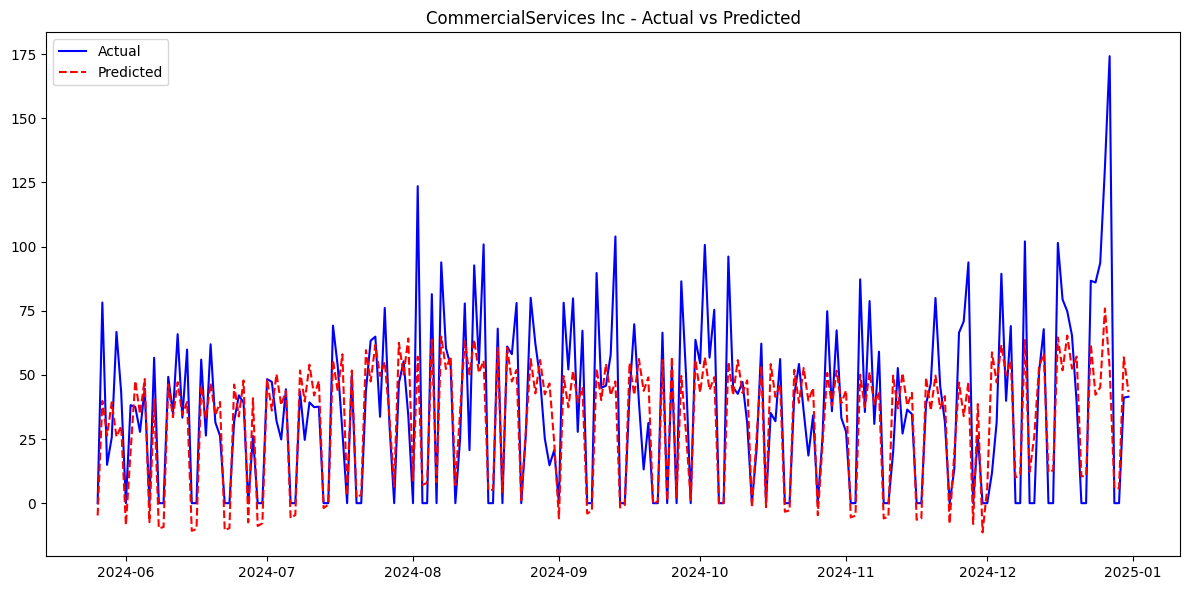

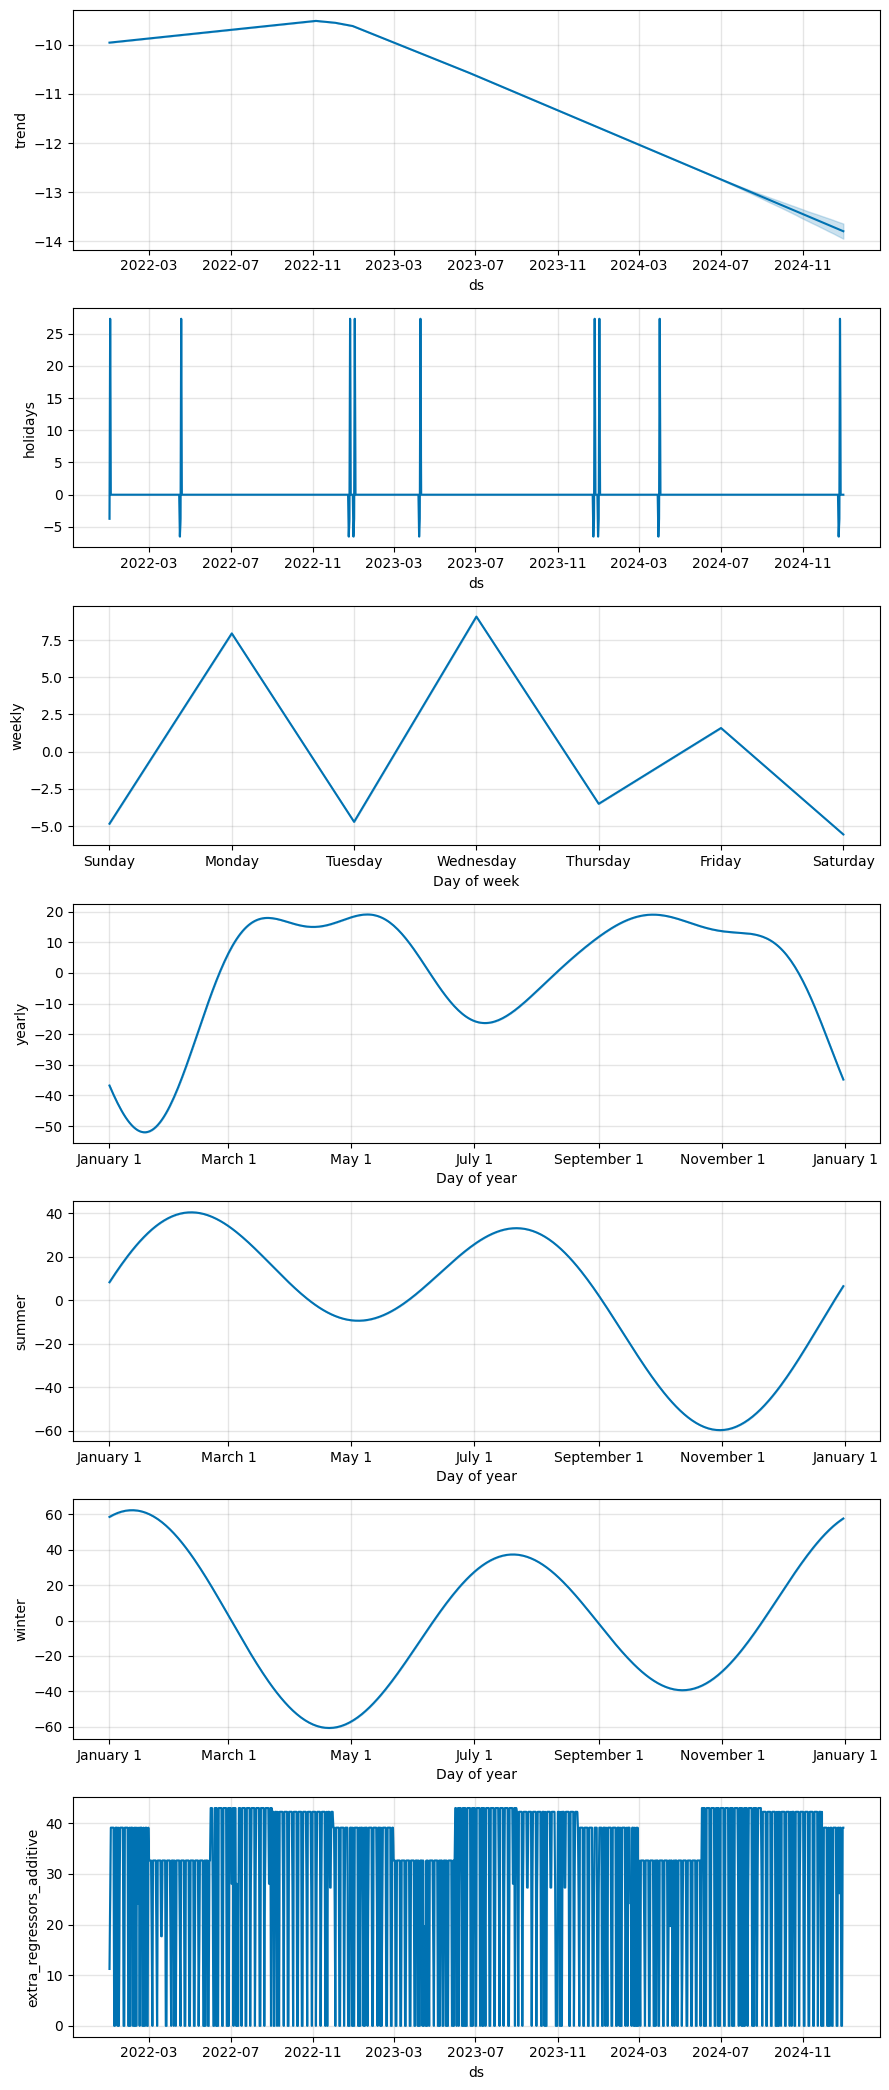


--- Processing MunicipalWaste Co ---

Data for MunicipalWaste Co:
Original first 3 values: [ 0.          0.         95.68523062]
Transferred first 3 values: [ 0.          0.         95.68523062]
NaN count in original: 0
NaN count in new df: 0
Training data shape: (876, 12)
Test data shape: (220, 12)


01:10:40 - cmdstanpy - INFO - Chain [1] start processing
01:10:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE for MunicipalWaste Co: 27.81


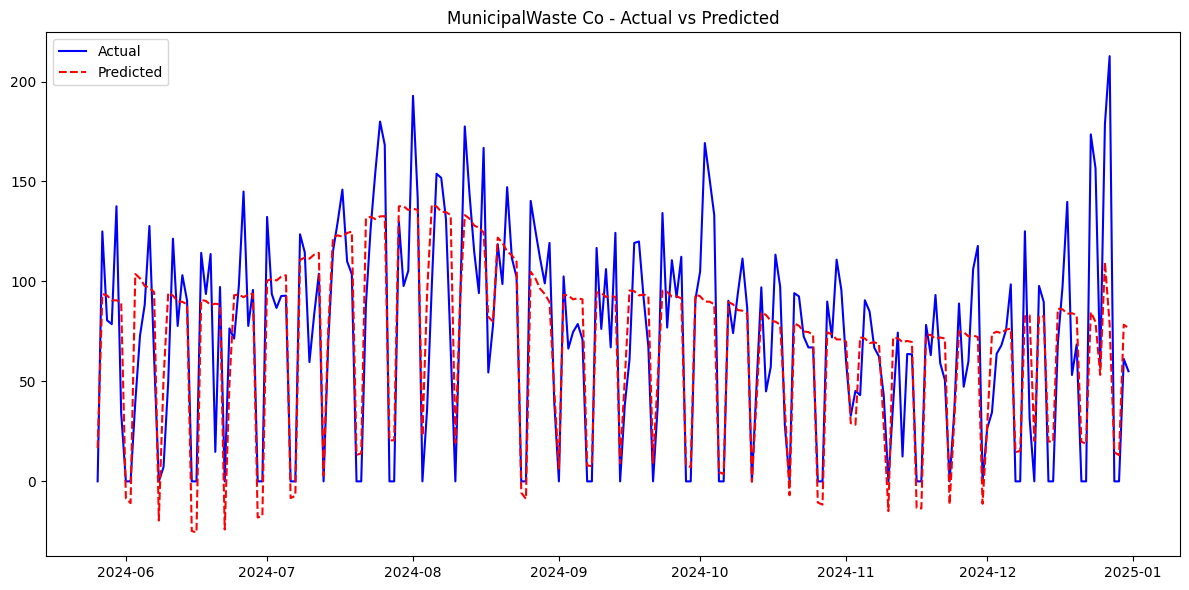

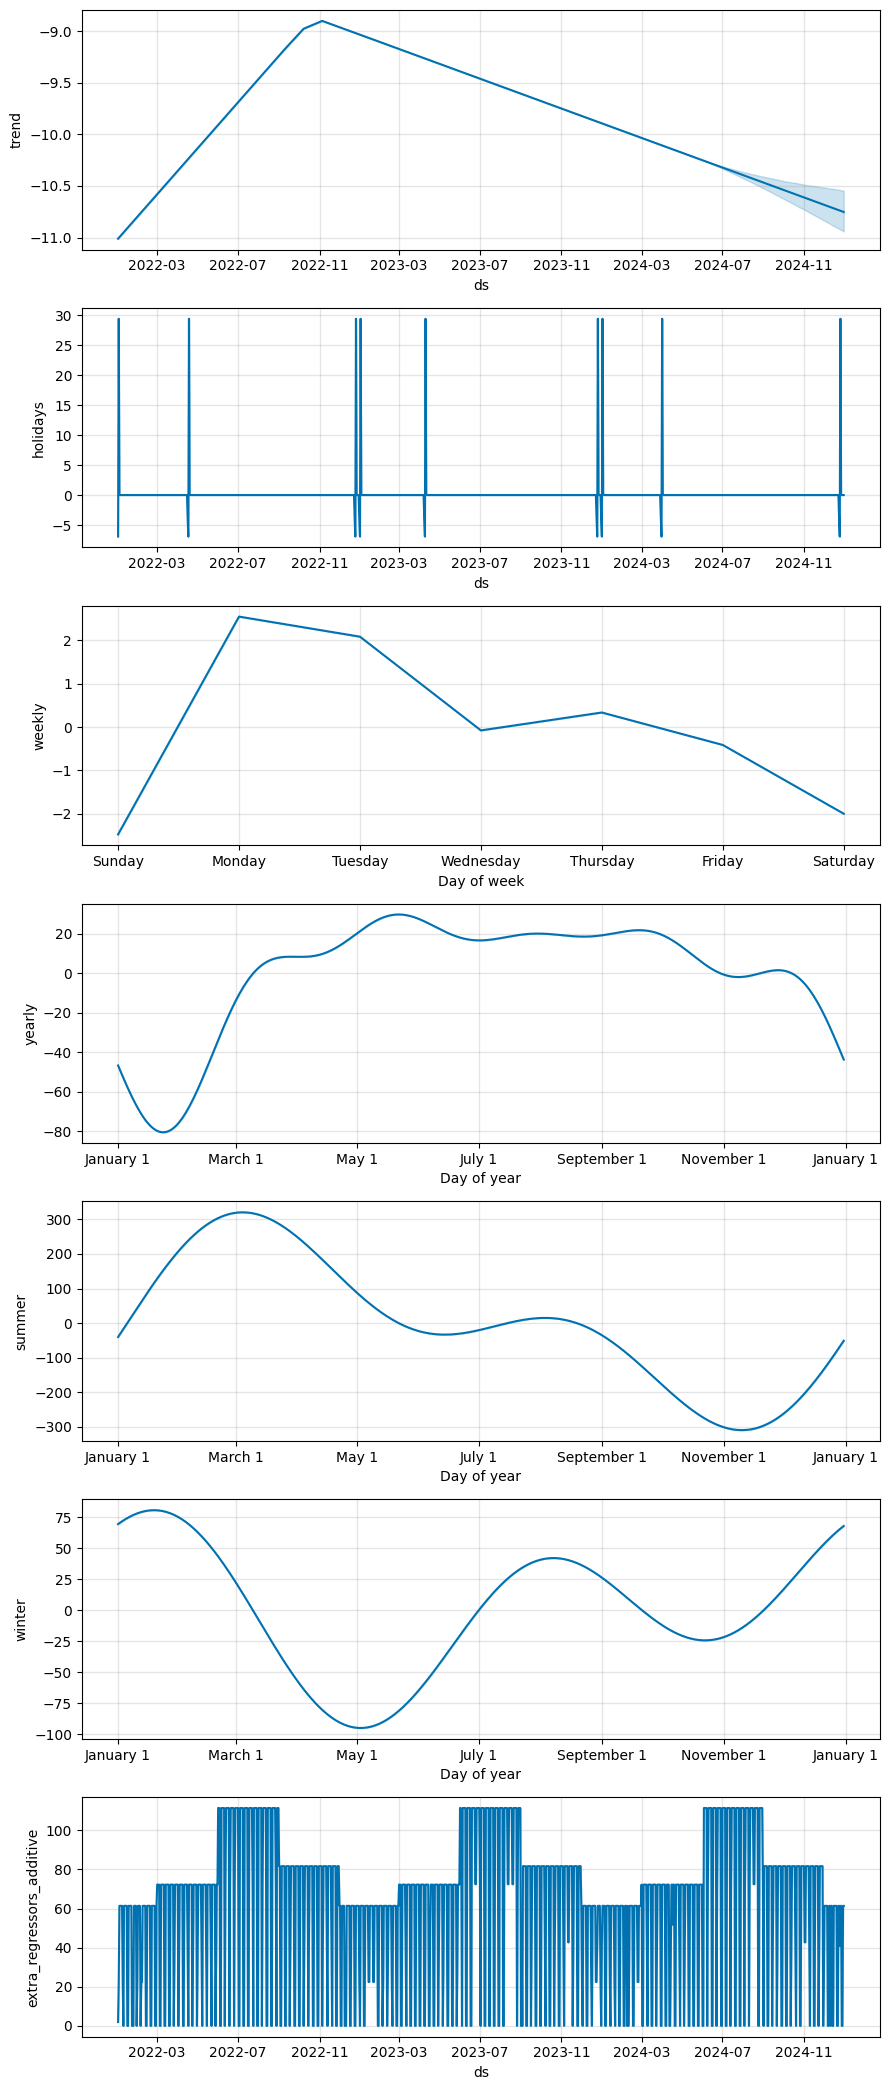


Data for RegionalWaste Management:
Original first 3 values: [ 51.82829298   0.         167.39980577]
Transferred first 3 values: [ 51.82829298   0.         167.39980577]
NaN count in original: 0
NaN count in new df: 0

Data for GreenWaste Solutions:
Original first 3 values: [ 8.73102334 19.19086704 41.6481167 ]
Transferred first 3 values: [ 8.73102334 19.19086704 41.6481167 ]
NaN count in original: 0
NaN count in new df: 0

Data for IndustrialProcess Ltd:
Original first 3 values: [ 80.97550717 117.60678942 141.70334477]
Transferred first 3 values: [ 80.97550717 117.60678942 141.70334477]
NaN count in original: 0
NaN count in new df: 0

Data for BuildRight Construction:
Original first 3 values: [12.31667987 35.09618915 42.85189942]
Transferred first 3 values: [12.31667987 35.09618915 42.85189942]
NaN count in original: 0
NaN count in new df: 0

Data for CommercialServices Inc:
Original first 3 values: [ 0.         73.95243233 84.8513772 ]
Transferred first 3 values: [ 0.         73.952

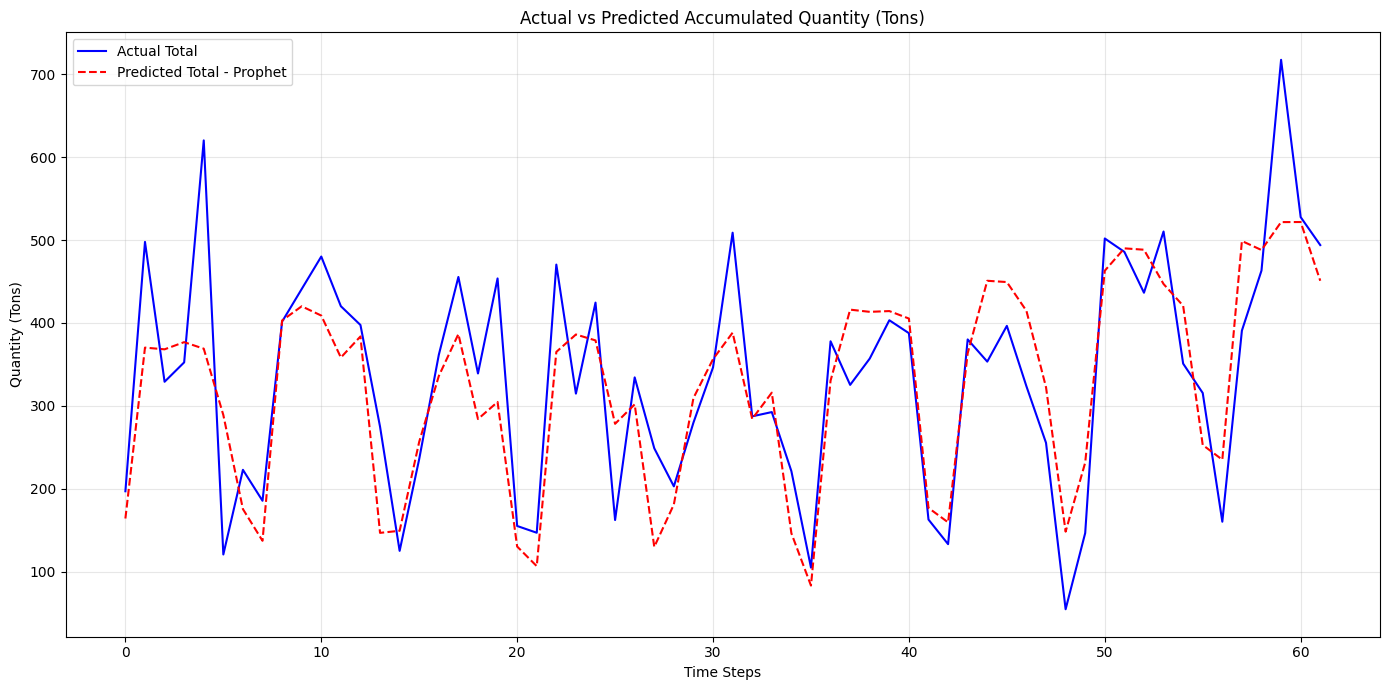

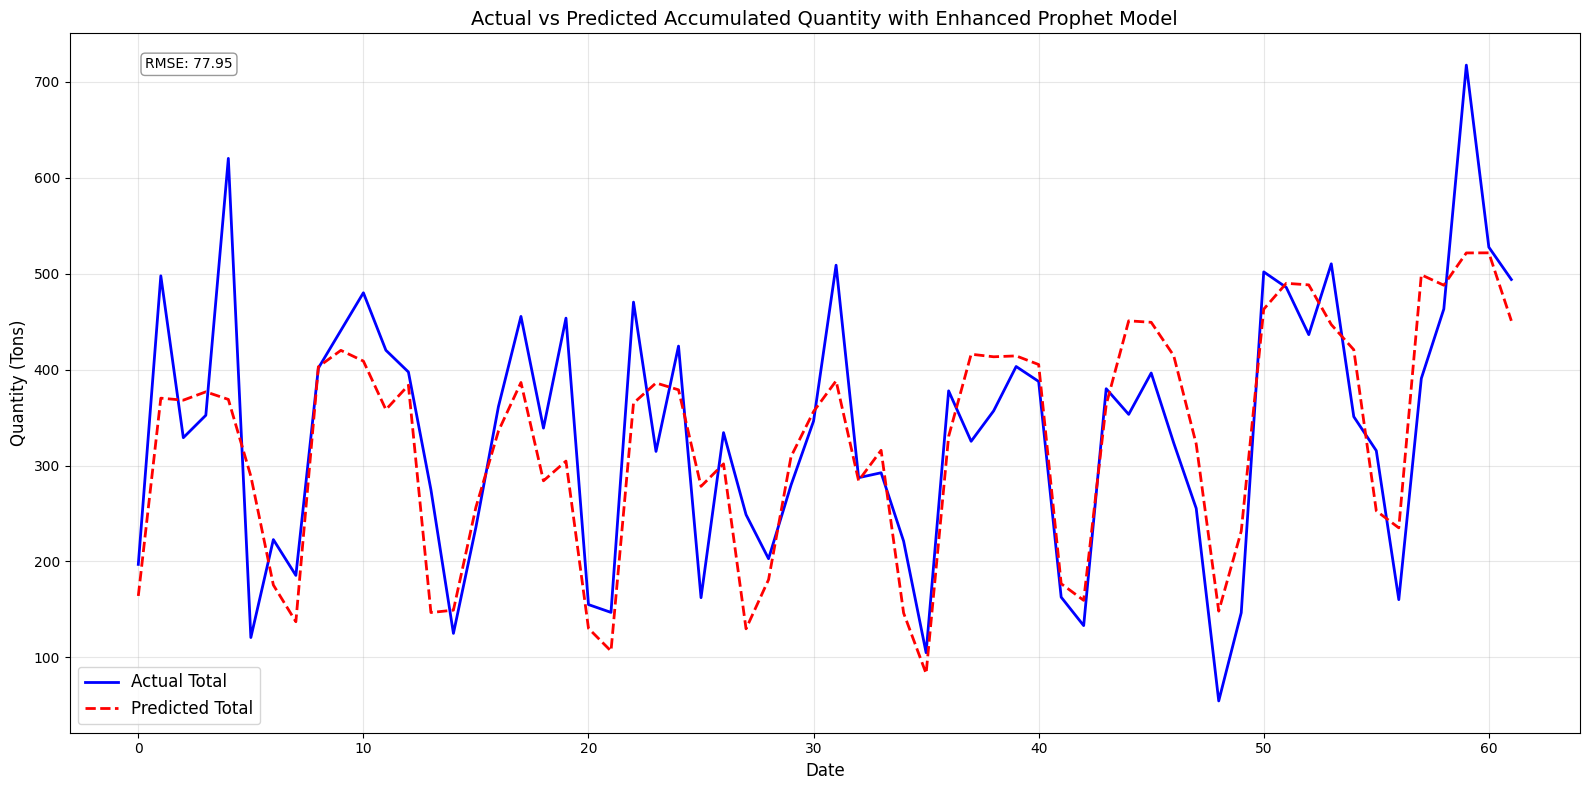

In [ ]:
# Dictionary to store Prophet models and predictions
prophet_models = {}
prophet_predictions = {}

# Import necessary libraries if not already imported
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error

# Function to properly prepare data for Prophet
def prepare_prophet_data(data, company_name, target_col='quantity_tons'):
    """
    Prepare data for Prophet with correct data transfer
    """
    # Create a new DataFrame with explicit copying of data
    prophet_df = pd.DataFrame()
    
    # Copy the DatetimeIndex to the ds column
    if isinstance(data.index, pd.DatetimeIndex):
        prophet_df['ds'] = data.index.copy()
    else:
        prophet_df['ds'] = pd.date_range(start='2022-01-01', periods=len(data), freq='D')
    
    # CRITICAL FIX: Explicitly copy the target column values
    # The issue was in how the data was being transferred
    prophet_df['y'] = data[target_col].values.copy()
    
    # Debug information
    print(f"\nData for {company_name}:")
    print(f"Original first 3 values: {data[target_col].head(3).values}")
    print(f"Transferred first 3 values: {prophet_df['y'].head(3).values}")
    print(f"NaN count in original: {data[target_col].isna().sum()}")
    print(f"NaN count in new df: {prophet_df['y'].isna().sum()}")
    
    # Add regressor columns
    for col in data.columns:
        if col != target_col:
            prophet_df[col] = data[col].values.copy()
    
    # Verify data is valid
    if prophet_df['y'].isna().all():
        raise ValueError(f"All target values are NaN for {company_name}")
    
    return prophet_df

# Function to add seasonal conditions to dataframe
def add_season_conditions(df):
    # Convert to datetime if not already
    if 'ds' in df.columns and not pd.api.types.is_datetime64_any_dtype(df['ds']):
        df['ds'] = pd.to_datetime(df['ds'])
    
    # Northern hemisphere seasons (rough dates)
    df['is_winter'] = ((df['ds'].dt.month == 12) | 
                       (df['ds'].dt.month == 1) | 
                       (df['ds'].dt.month == 2)).astype(int)
    
    df['is_summer'] = ((df['ds'].dt.month == 6) | 
                       (df['ds'].dt.month == 7) | 
                       (df['ds'].dt.month == 8)).astype(int)
    
    
    return df

# Create holiday dataframe
holidays_df = pd.DataFrame({
    'holiday': 'holiday',
    'ds': pd.to_datetime([
        '2022-01-01',  # Neujahr
        '2022-12-25',  # Weihnachten
        '2022-04-17',  # Ostern
        '2023-01-01',  # Neujahr
        '2023-12-25',  # Weihnachten
        '2023-04-09',  # Ostern (corrected date for 2023)
        '2024-01-01',  # Neujahr
        '2024-12-25',  # Weihnachten
        '2024-03-31'   # Ostern (corrected date for 2024)
    ]),
    'lower_window': -1,  # Include day before
    'upper_window': 1    # Include day after
})

# Train and evaluate Prophet models for each company
for company, df in gru_company_dfs.items():
    print(f"\n--- Processing {company} ---")
    
    try:
        # Prepare data for Prophet
        prophet_df = prepare_prophet_data(df, company)
        
        # Split into training and testing sets
        train_size = int(len(prophet_df) * 0.8)
        train_df = prophet_df.iloc[:train_size].copy()
        test_df = prophet_df.iloc[train_size:].copy()
        
        # Add seasonal conditions
        train_df = add_season_conditions(train_df)
        test_df = add_season_conditions(test_df)
        
        print(f"Training data shape: {train_df.shape}")
        print(f"Test data shape: {test_df.shape}")
        
        # Create Prophet model with enhanced configuration
        model = Prophet(
            yearly_seasonality=5,  # Increased Fourier terms for yearly seasonality
            weekly_seasonality=True,
            daily_seasonality=False,
            seasonality_mode='additive',  # Better for seasonal effects that scale with trend
            changepoint_prior_scale=0.1,  # Slightly more flexibility in trend changes
            holidays=holidays_df
        )
        
        # Add custom seasonalities
        model.add_seasonality(
            name='winter', 
            period=365.25, 
            fourier_order=2,
            condition_name='is_winter'
        )
        
        model.add_seasonality(
            name='summer', 
            period=365.25, 
            fourier_order=2,
            condition_name='is_summer'
        )
        
  
        
        # Add regressors
        for col in df.columns:
            if col != 'quantity_tons':
                model.add_regressor(col)
        
        # Fit model
        model.fit(train_df)
        
        # Store the trained model
        prophet_models[company] = model
        
        # Create future dataframe for predictions
        future = pd.concat([train_df, test_df])
        future = add_season_conditions(future)  # Ensure seasonal conditions are applied
        
        # Make predictions
        forecast = model.predict(future)
        
        # Extract relevant predictions for test period
        test_predictions = forecast.iloc[train_size:]['yhat'].values
        prophet_predictions[company] = test_predictions
        
        # Calculate RMSE for this company
        actual = test_df['y'].values
        rmse = np.sqrt(mean_squared_error(actual, test_predictions))
        print(f"Prophet RMSE for {company}: {rmse:.2f}")
        
        # Visualize predictions for this company
        plt.figure(figsize=(12, 6))
        plt.plot(test_df['ds'], test_df['y'], 'b-', label='Actual')
        plt.plot(test_df['ds'], test_predictions, 'r--', label='Predicted')
        plt.title(f'{company} - Actual vs Predicted')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # Plot forecast components
        fig = model.plot_components(forecast)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error processing {company}: {str(e)}")
        continue

# Proceed with ensemble metrics if we have successful predictions
if prophet_predictions:
    # Ensure all prediction arrays are the same length
    min_length = min(len(preds) for preds in prophet_predictions.values())
    
    # Normalize predictions to the same length
    aligned_predictions = {company: preds[:min_length] for company, preds in prophet_predictions.items()}
    
    # Aggregate predictions from all companies
    total_predicted = np.sum(list(aligned_predictions.values()), axis=0)
    
    # Get test data for actual values
    successful_companies = list(prophet_predictions.keys())
    actual_values = []
    
    for company in successful_companies:
        prophet_df = prepare_prophet_data(gru_company_dfs[company], company)
        train_size = int(len(prophet_df) * 0.8)
        company_actual = prophet_df['y'].values[train_size:train_size+min_length]
        actual_values.append(company_actual)
    
    total_actual = np.sum(actual_values, axis=0)
    
    # Calculate RMSE for the ensemble
    ensemble_rmse = np.sqrt(mean_squared_error(total_actual, total_predicted))
    print(f'\nEnsemble Prophet RMSE: {ensemble_rmse:.2f}')
    
    # Define the range for evaluation (similar to your LSTM code)
    num = 0  # Starting index
    num2 = min(62, len(total_actual))  # Ending index
    
    # Calculate RMSE for a specific range
    range_rmse = np.sqrt(mean_squared_error(total_actual[num:num2], total_predicted[num:num2]))
    print(f'Ensemble Prophet RMSE for predictions {num} to {num2-1}: {range_rmse:.2f}')
    
    # Visualize ensemble results
    plt.figure(figsize=(14, 7))
    plt.plot(total_actual[num:num2], label='Actual Total', color='blue')
    plt.plot(total_predicted[num:num2], label='Predicted Total - Prophet', color='red', linestyle='--')
    plt.xlabel('Time Steps')
    plt.ylabel('Quantity (Tons)')
    plt.title('Actual vs Predicted Accumulated Quantity (Tons)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Optional: Create a more detailed visualization
    plt.figure(figsize=(16, 8))
    
    # Create date range for x-axis
    if pd.api.types.is_datetime64_any_dtype(prophet_df['ds'].iloc[0]):
        first_test_date = prophet_df['ds'].iloc[train_size]
        dates = pd.date_range(start=first_test_date, periods=num2-num, freq='D')
        plt.plot(dates, total_actual[num:num2], label='Actual Total', color='blue', linewidth=2)
        plt.plot(dates, total_predicted[num:num2], label='Predicted Total', color='red', 
                 linestyle='--', linewidth=2)
        plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
        plt.gcf().autofmt_xdate()
    else:
        plt.plot(total_actual[num:num2], label='Actual Total', color='blue', linewidth=2)
        plt.plot(total_predicted[num:num2], label='Predicted Total', color='red', 
                 linestyle='--', linewidth=2)
    
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Quantity (Tons)', fontsize=12)
    plt.title('Actual vs Predicted Accumulated Quantity with Enhanced Prophet Model', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add RMSE annotation
    plt.annotate(f'RMSE: {range_rmse:.2f}', 
                 xy=(0.05, 0.95), 
                 xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
else:
    print("No successful predictions. Check the errors above.")

In [19]:
# Example usage
waste_types = fetcher.waste_data['waste_type'].unique()
waste_type_dfs = {}

for waste_type in waste_types:
    prep_data_waste = fetcher.prepare_quantity_tons_by_waste_type(waste_type)
    waste_type_dfs[waste_type] = fetcher.create_boosting_features(prep_data_waste)

# Check the prepared data for a specific waste type
print(waste_type_dfs['Organic'])



            is_weekend  is_holiday  is_Fall  is_Spring  is_Summer  is_Winter  \
date                                                                           
2022-01-01         1.0         1.0      0.0        0.0        0.0        1.0   
2022-01-02         1.0         0.0      0.0        0.0        0.0        1.0   
2022-01-03         0.0         0.0      0.0        0.0        0.0        1.0   
2022-01-04         0.0         0.0      0.0        0.0        0.0        1.0   
2022-01-05         0.0         0.0      0.0        0.0        0.0        1.0   
...                ...         ...      ...        ...        ...        ...   
2024-12-27         0.0         0.0      0.0        0.0        0.0        1.0   
2024-12-28         1.0         0.0      0.0        0.0        0.0        1.0   
2024-12-29         1.0         0.0      0.0        0.0        0.0        1.0   
2024-12-30         0.0         0.0      0.0        0.0        0.0        1.0   
2024-12-31         0.0         0.0      

In [20]:

# Dictionary to store models, predictions, and RMSEs
waste_type_models = {}
waste_type_predictions = {}
waste_type_naive_predictions = {}
waste_type_rmses = {}
waste_type_naive_rmses = {}

# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': np.arange(70, 200, 10),
    'learning_rate': np.arange(0.01, 0.14, 0.01),
    'max_depth': [2, 3, 4, 5],
    'subsample': [0.6, 0.7, 1.0]
}

# Train models and make predictions for each waste type
for waste_type, df in waste_type_dfs.items():
    # Split data into features (X) and target (y)
    X = df.drop(columns=['quantity_tons'])
    y = df['quantity_tons']

    # Train-test split
    split_index = int(len(df) * 0.8)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Initialize the XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

    # Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=3)

    # Perform Grid Search
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',  # Use RMSE for scoring
        cv=tscv,  # Time Series Cross-Validation
        verbose=1,  # Print progress
        n_jobs=-1  # Use all available CPU cores
    )
    grid_search.fit(X_train, y_train)

    # Store the best model
    best_model = grid_search.best_estimator_
    waste_type_models[waste_type] = best_model

    # Print the best parameters for this waste type
    print(f"Best parameters for {waste_type}: {grid_search.best_params_}")

    # Make predictions with the best model
    y_pred = best_model.predict(X_test)
    waste_type_predictions[waste_type] = y_pred

    # Calculate RMSE for XGBoost predictions
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    waste_type_rmses[waste_type] = rmse
    print(f"XGBoost RMSE for {waste_type}: {rmse:.2f}")

    # Naive Forecast: Use the last observed value in the training set
    naive_pred = np.full_like(y_test, y_train.iloc[-1])  # Repeat the last training value
    waste_type_naive_predictions[waste_type] = naive_pred

    # Calculate RMSE for Naive Forecast
    naive_rmse = np.sqrt(mean_squared_error(y_test, naive_pred))
    waste_type_naive_rmses[waste_type] = naive_rmse
    print(f"Naive Forecast RMSE for {waste_type}: {naive_rmse:.2f}")

# Aggregate predictions
total_predicted = np.sum(list(waste_type_predictions.values()), axis=0)
total_naive_predicted = np.sum(list(waste_type_naive_predictions.values()), axis=0)

# Aggregate actual values
total_actual = np.sum([waste_type_dfs[waste_type]['quantity_tons'][split_index:] for waste_type in waste_type_dfs.keys()], axis=0)

# Calculate RMSE for the ensemble
ensemble_rmse = np.sqrt(mean_squared_error(total_actual, total_predicted))
print(f'Ensemble XGBoost RMSE: {ensemble_rmse:.2f}')

# Calculate RMSE for the naive forecast
naive_ensemble_rmse = np.sqrt(mean_squared_error(total_actual, total_naive_predicted))
print(f'Ensemble Naive Forecast RMSE: {naive_ensemble_rmse:.2f}')

# Visualize actual vs predicted accumulated quantity_tons
plt.figure(figsize=(12, 6))
plt.plot(feature_data.index[split_index:], total_actual, label='Actual Quantity (Tons)', color='blue')
plt.plot(feature_data.index[split_index:], total_predicted, label='Predicted Quantity (Tons) - XGBoost', color='red', linestyle='--')
plt.plot(feature_data.index[split_index:], total_naive_predicted, label='Predicted Quantity (Tons) - Naive Forecast', color='green', linestyle=':')
plt.xlabel('Date')
plt.ylabel('Quantity (Tons)')
plt.title('Actual vs Predicted Accumulated Quantity (Tons)')
plt.legend()
plt.show()

Fitting 3 folds for each of 2028 candidates, totalling 6084 fits


KeyboardInterrupt: 

In [ ]:


# Dictionary to store models, predictions, and RMSEs
waste_type_models = {}
waste_type_predictions = {}
waste_type_naive_predictions = {}
waste_type_gru_predictions = {}
waste_type_rmses = {}
waste_type_naive_rmses = {}
waste_type_gru_rmses = {}

# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': np.arange(70, 200, 10),
    'learning_rate': np.arange(0.01, 0.14, 0.01),
    'max_depth': [2, 3, 4, 5],
    'subsample': [0.6, 0.7, 1.0]
}

# Define GRU model in PyTorch
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Train models and make predictions for each waste type
for waste_type, df in waste_type_dfs.items():
    # Split data into features (X) and target (y)
    X = df.drop(columns=['quantity_tons'])
    y = df['quantity_tons']

    # Train-test split
    split_index = int(len(df) * 0.8)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Initialize the XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

    # Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=2)

    # Perform Grid Search
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',  # Use RMSE for scoring
        cv=tscv,  # Time Series Cross-Validation
        verbose=1,  # Print progress
        n_jobs=-1  # Use all available CPU cores
    )
    grid_search.fit(X_train, y_train)

    # Store the best model
    best_model = grid_search.best_estimator_
    waste_type_models[waste_type] = best_model

    # Print the best parameters for this waste type
    print(f"Best parameters for {waste_type}: {grid_search.best_params_}")

    # Make predictions with the best model
    y_pred = best_model.predict(X_test)
    waste_type_predictions[waste_type] = y_pred

    # Calculate RMSE for XGBoost predictions
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    waste_type_rmses[waste_type] = rmse
    print(f"XGBoost RMSE for {waste_type}: {rmse:.2f}")

    # Naive Forecast: Use the last observed value in the training set
    naive_pred = np.full_like(y_test, y_train.iloc[-1])  # Repeat the last training value
    waste_type_naive_predictions[waste_type] = naive_pred

    # Calculate RMSE for Naive Forecast
    naive_rmse = np.sqrt(mean_squared_error(y_test, naive_pred))
    waste_type_naive_rmses[waste_type] = naive_rmse
    print(f"Naive Forecast RMSE for {waste_type}: {naive_rmse:.2f}")

    # GRU Model
    # Prepare data for GRU
    timesteps = 7
    X_train_gru, y_train_gru, X_test_gru, y_test_gru, scaler = fetcher.gru_prepare_quantity_tons_by_waste_type(waste_type, timesteps=timesteps)
    print(X_train_gru.shape, y_train_gru.shape, X_test_gru.shape, y_test_gru.shape)

    # Convert data to PyTorch tensors
    X_train_gru = torch.tensor(X_train_gru, dtype=torch.float32)
    y_train_gru = torch.tensor(y_train_gru, dtype=torch.float32)
    X_test_gru = torch.tensor(X_test_gru, dtype=torch.float32)
    y_test_gru = torch.tensor(y_test_gru, dtype=torch.float32)

    # Create DataLoader
    train_dataset = TensorDataset(X_train_gru, y_train_gru)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Initialize GRU model
    input_size = 1  # Number of features (quantity_tons)
    hidden_size = 50  # Number of hidden units
    output_size = 1  # Number of output features
    gru_model = GRUModel(input_size, hidden_size, output_size)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.001)

    # Train GRU model
    num_epochs = 50
    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            # Forward pass
            outputs = gru_model(batch_X)
            loss = criterion(outputs, batch_y)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Make predictions with GRU model
    gru_model.eval()
    with torch.no_grad():
        y_pred_gru_scaled = gru_model(X_test_gru).numpy()
    y_pred_gru = scaler.inverse_transform(y_pred_gru_scaled).flatten()

    # Store GRU predictions as a 1D array
    waste_type_gru_predictions[waste_type] = y_pred_gru

    # Calculate RMSE for GRU predictions
    gru_rmse = np.sqrt(mean_squared_error(y_test_gru, y_pred_gru))
    waste_type_gru_rmses[waste_type] = gru_rmse
    print(f"GRU RMSE for {waste_type}: {gru_rmse:.2f}")

# Aggregate GRU predictions
# Convert dictionary of GRU predictions into a 2D array
gru_predictions_array = np.array(list(waste_type_gru_predictions.values()))

# Sum the predictions along the rows (axis=0)
total_gru_predicted = np.sum(gru_predictions_array, axis=0)

# Aggregate XGBoost and naive predictions
total_predicted = np.sum(list(waste_type_predictions.values()), axis=0)
total_naive_predicted = np.sum(list(waste_type_naive_predictions.values()), axis=0)

# Aggregate actual values
total_actual = np.sum([waste_type_dfs[waste_type]['quantity_tons'][split_index:] for waste_type in waste_type_dfs.keys()], axis=0)

# Calculate RMSE for the ensemble
ensemble_rmse = np.sqrt(mean_squared_error(total_actual, total_predicted))
print(f'Ensemble XGBoost RMSE: {ensemble_rmse:.2f}')

# Calculate RMSE for the naive forecast
naive_ensemble_rmse = np.sqrt(mean_squared_error(total_actual, total_naive_predicted))
print(f'Ensemble Naive Forecast RMSE: {naive_ensemble_rmse:.2f}')

# Calculate RMSE for the GRU forecast
gru_ensemble_rmse = np.sqrt(mean_squared_error(total_actual[timesteps:], total_gru_predicted))
print(f'Ensemble GRU RMSE: {gru_ensemble_rmse:.2f}')

# Visualize actual vs predicted accumulated quantity_tons
plt.figure(figsize=(12, 6))
plt.plot(feature_data.index[split_index:], total_actual, label='Actual Quantity (Tons)', color='blue')
plt.plot(feature_data.index[split_index:], total_predicted, label='Predicted Quantity (Tons) - XGBoost', color='red', linestyle='--')
plt.plot(feature_data.index[split_index:], total_naive_predicted, label='Predicted Quantity (Tons) - Naive Forecast', color='green', linestyle=':')
plt.plot(feature_data.index[split_index + timesteps:], total_gru_predicted, label='Predicted Quantity (Tons) - GRU', color='purple', linestyle='-.')
plt.xlabel('Date')
plt.ylabel('Quantity (Tons)')
plt.title('Actual vs Predicted Accumulated Quantity (Tons)')
plt.legend()
plt.show()

Fitting 2 folds for each of 2028 candidates, totalling 4056 fits
Best parameters for Municipal: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 80, 'subsample': 0.7}
XGBoost RMSE for Municipal: 50.41
Naive Forecast RMSE for Municipal: 127.91
(5409, 7, 1) (5409, 1) (1347, 7, 1) (1347, 1)
GRU RMSE for Municipal: 19.23
Fitting 2 folds for each of 2028 candidates, totalling 4056 fits
Best parameters for Industrial: {'learning_rate': 0.09999999999999999, 'max_depth': 2, 'n_estimators': 160, 'subsample': 0.7}
XGBoost RMSE for Industrial: 36.68
Naive Forecast RMSE for Industrial: 78.33
(1882, 7, 1) (1882, 1) (466, 7, 1) (466, 1)
GRU RMSE for Industrial: 28.86
Fitting 2 folds for each of 2028 candidates, totalling 4056 fits
Best parameters for Organic: {'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 70, 'subsample': 1.0}
XGBoost RMSE for Organic: 35.02
Naive Forecast RMSE for Organic: 54.92
(2736, 7, 1) (2736, 1) (679, 7, 1) (679, 1)
GRU RMSE for Organic: 18.13
Fitting 2 folds 

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.